In [73]:
import math
import time
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,RandomSampler

In [74]:
device = torch.device("cpu")

n = 100 

r = 0.05;gamma = 0.05
sigma = 0.3;T = 1

x_start = -np.exp(4*sigma*np.sqrt(T));x_end = np.exp(4*sigma*np.sqrt(T))
t_start = 0.;t_end = 1.

x = np.linspace(x_start,x_end,100 )
t = np.linspace(t_start,t_end,100 )
x, t = np.meshgrid(x, t)
x = np.reshape(x, (np.size(x[:]),1))
t = np.reshape(t, (np.size(t[:]),1))

x_left = np.linspace(x_start,x_start, 100 )
t_left = np.linspace(t_start,t_end, 100 ) 
v_left = np.zeros(100)
x_left = x_left.reshape(-1, 1)
t_left = t_left.reshape(-1, 1)
v_left = v_left.reshape(-1, 1)

x_up = np.linspace(x_start,x_end, 100 )
t_up = np.linspace(t_end,t_end, 100 ) 
v_up = (x_up > 0)*x_up
x_up = x_up.reshape(-1, 1)
t_up = t_up.reshape(-1, 1)
v_up = v_up.reshape(-1, 1)

x_right = np.linspace(x_end,x_end, 100 )
t_right = np.linspace(t_start,t_end, 100 ) 
v_right = np.exp(-r*(T-t_right))
x_right = x_right.reshape(-1, 1)
t_right = t_right.reshape(-1, 1)
v_right = v_right.reshape(-1, 1)


x_bound = [x_left,x_up,x_right]
t_bound = [t_left,t_up,t_right]
v_bound = [v_left,v_up,v_right]

#xnet = torch.Tensor(x).to(device)
#tnet = torch.Tensor(t).to(device) 

d = -np.log(1 + np.abs(x))/(sigma*np.sqrt(T-t)) + (sigma/2)*np.sqrt(T-t) 

for i in range(9900,10000):
    d[i] = -100000

actual_soln = np.exp(-gamma* (T - t))*((x > 0)*(x) + (d*sigma*np.sqrt(T - t) + 1)* norm.cdf(d)/2 - (np.abs(x) + 1)* norm.cdf(d - np.sqrt(T-t))/2  + (sigma*np.sqrt(T - t))* norm.pdf(d))  

C:\Users\bsaty\AppData\Local\Temp\ipykernel_6484\142852391.py:46: RuntimeWarning: divide by zero encountered in divide
  d = -np.log(1 + np.abs(x))/(sigma*np.sqrt(T-t)) + (sigma/2)*np.sqrt(T-t)


In [51]:
def train(device,x,t,x_bound,t_bound,v_bound,learning_rate,basis_num,epochs,batch_flag,batch_size):

	xnet = torch.Tensor(x).to(device)
	tnet = torch.Tensor(t).to(device) 
	x_left,x_up,x_right = x_bound
	t_left,t_up,t_right = t_bound
	V_left,V_up,V_right = v_bound

	x_left = torch.Tensor(x_left).to(device) 	
	t_left = torch.Tensor(t_left).to(device) 	
	V_left = torch.Tensor(V_left).to(device)
	x_up = torch.Tensor(x_up).to(device) 	
	t_up = torch.Tensor(t_up).to(device) 	
	V_up = torch.Tensor(V_up).to(device)
	x_right = torch.Tensor(x_right).to(device) 	
	t_right = torch.Tensor(t_right).to(device) 	
	V_right = torch.Tensor(V_right).to(device)

	if(batch_flag):
		dataset = TensorDataset(xnet,tnet)
		dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True,num_workers = 0,drop_last = True )
		print(len(dataloader))

	def lag_coeffs(num):
		lis = [np.array([1]),np.array([1,-1])]
		for n in range(1,num-1):
			xl1 = np.concatenate((np.array([0]),lis[n]),axis = 0)
			l1 = np.concatenate((lis[n],np.array([0])),axis = 0)		
			l0 = np.concatenate((lis[n-1],np.array([0,0])),axis = 0)
			l = ((2*n + 1)*l1 - xl1 - n*l0)/(n + 1)
			lis.append(l)
		for n in range(num):
			lis[n] = np.concatenate((lis[n],np.array([0]*(num-1-n))),axis = 0)
		return lis

	def poly(coeffs,x):
		sum = torch.zeros_like(x)
		for i,coeff in enumerate(coeffs):
			sum = sum + coeff*(x**i)
		return sum

	class Net(nn.Module):
		def __init__(self):
			super(Net, self).__init__()
			self.main = nn.Sequential(
				#nn.Linear(2*basis_num,2*basis_num),
				nn.Linear(2*basis_num,1)
			)		
		def forward(self,input):
			coeffs = lag_coeffs(basis_num)
			x = input[:,0]
			t = input[:,1]
			netin = torch.Tensor([])
			#print(input)
			for i in range(basis_num):
				netin = torch.cat((netin,poly(coeffs[i],x.view(-1,1))),1)
			for i in range(basis_num):
				netin = torch.cat((netin,poly(coeffs[i],t.view(-1,1))),1)
			#print(netin)
			netout = self.main(netin)
			return netout

	net = Net().to(device)
	
	def init_normal(m):
		if type(m) == nn.Linear:
			nn.init.kaiming_normal_(m.weight)

	net.apply(init_normal)

	optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

	def Loss_criterion(xnet,tnet):
		xnet.requires_grad = True
		tnet.requires_grad = True
		points = torch.cat((xnet,tnet),1) 
		V = net(points)
		V = V.view(len(V),-1)
		V_x = torch.autograd.grad(V,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		V_xx = torch.autograd.grad(V_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		V_t = torch.autograd.grad(V,tnet,grad_outputs=torch.ones_like(tnet),create_graph = True,only_inputs=True)[0]
		u = ((r - gamma)*V_x - xnet*(sigma**2)*V_xx > 0).long()
		loss = V_t + (u - xnet)*(r - gamma)*V_x + ((u - xnet)**2)*(sigma**2)*V_xx/2 - gamma * V
		return nn.MSELoss()(loss,torch.zeros_like(loss)) 

	def Loss_BC(x_left,t_left,V_left,x_up,t_up,V_up,x_right,t_right,V_right):
		x_right.requires_grad = True
		left = torch.cat((x_left, t_left), 1)
		out = net(left)
		V_left_pred = out.view(len(out), -1)
		loss_f = nn.MSELoss()
		loss_left = loss_f(V_left_pred,V_left)

		up = torch.cat((x_up, t_up), 1)
		out = net(up)
		V_up_pred = out.view(len(out), -1)
		loss_f = nn.MSELoss()
		loss_up = loss_f(V_up_pred,V_up)
		
		right = torch.cat((x_right, t_right), 1)
		out = net(right)
		V_right_pred = out.view(len(out), -1)
		Vx_right_pred = torch.autograd.grad(V_right_pred,x_right,grad_outputs=torch.ones_like(x_right),create_graph = True,only_inputs=True)[0]
		loss_f = nn.MSELoss()
		loss_right = loss_f(Vx_right_pred,V_right)

		loss_bc = loss_right + loss_left + loss_up
		return loss_bc,loss_right,loss_left,loss_up


	losses = []
	tic = time.time()

	xx = np.linspace(x_start,x_end,100);tt = np.linspace(t_start,t_end,100)
	xx,tt = np.meshgrid(xx,tt)

	if(batch_flag):
		for epoch in range(epochs):
			if epoch == 250:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
			for batch_idx, (x_in,t_in) in enumerate(dataloader):

				net.zero_grad()
				loss_eqn = Loss_criterion(x_in,t_in)
				loss_bc,loss_right,loss_left,loss_up = Loss_BC(x_left,t_left,V_left,x_up,t_up,V_up,x_right,t_right,V_right)
				loss = loss_eqn + loss_bc
				loss.backward()

				optimizer.step() 
				if batch_idx % 20 ==0:
					print('\nTrain Epoch: {} \tLoss: {:.10f}\tEquation Loss: {:.10f} \t BC Loss {:.6f}\nRight_boundary loss {:.10f}\tLeft_boundary loss {:.10f}\tUp_boundary loss {:.10f}\n'.format(epoch, loss.item(),loss_eqn.item(),loss_bc.item(),loss_right.item(),loss_left.item(),loss_up.item()))

					
			points = torch.cat((xnet,tnet),1)
			U = net(points)
			z = U.detach().numpy()
			print(actual_soln)
			actual_loss = np.square(actual_soln - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.10f}\n'.format(
				epoch, actual_loss))

			if epoch % 1 == 0:
				ax = plt.axes(projection='3d')
				ax.plot_surface(xx,tt,z.reshape(100,100))
				plt.show()
			#if epoch % 50 == 0:
			#	print('Train Epoch: {} \tLoss: {:.10f}\tEquation Loss: {:.10f} \t BC Loss {:.6f}'.format(epoch, loss.item(),loss_eqn.item(),loss_bc.item()))
			#losses.append(loss.item())
					
	else:
		for epoch in range(epochs):
			if epoch == 2000:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
			net.zero_grad()
			loss_eqn = Loss_criterion(xnet,tnet)
			loss_bc,loss_right,loss_left,loss_up = Loss_BC(x_left,t_left,V_left,x_up,t_up,V_up,x_right,t_right,V_right)
			loss = loss_eqn + loss_bc
			loss.backward()
			
			optimizer.step() 
			points = torch.cat((xnet,tnet),1)
			U = net(points)
			z = U.detach().numpy()

			if epoch % 50 == 0:
				ax = plt.axes(projection='3d')
				ax.plot_surface(xx,tt,z.reshape(100,100))
				plt.show()
			if epoch % 10 == 0:
				print('\nTrain Epoch: {} \tLoss: {:.10f}\tEquation Loss: {:.10f} \t BC Loss {:.6f}\nRight_boundary loss {:.10f}\tLeft_boundary loss {:.10f}\tUp_boundary loss {:.10f}\n'.format(epoch, loss.item(),loss_eqn.item(),loss_bc.item(),loss_right.item(),loss_left.item(),loss_up.item()))
			
			losses.append(loss.item())

	toc = time.time()
	elapseTime = toc - tic
	print ("elapse time in parallel = ", elapseTime)

	net_in = torch.cat((xnet,tnet),1)
	output = net(net_in)  #evaluate model
	
	pred = net(torch.cat((x_up, t_up), 1))
	V_up_pred = pred.view(len(pred), -1)

	return output,V_up_pred


78

Train Epoch: 0 	Loss: 7256237.0000000000	Equation Loss: 257199.7031250000 	 BC Loss 6999037.500000
Right_boundary loss 6.1712694168	Left_boundary loss 6556407.0000000000	Up_boundary loss 442624.5937500000


Train Epoch: 0 	Loss: 6708960.5000000000	Equation Loss: 177098.4843750000 	 BC Loss 6531862.000000
Right_boundary loss 5.9809966087	Left_boundary loss 6119075.0000000000	Up_boundary loss 412781.0312500000


Train Epoch: 0 	Loss: 6291644.5000000000	Equation Loss: 206638.9375000000 	 BC Loss 6085005.500000
Right_boundary loss 5.7951898575	Left_boundary loss 5700752.5000000000	Up_boundary loss 384247.0937500000


Train Epoch: 0 	Loss: 5849870.5000000000	Equation Loss: 191181.0156250000 	 BC Loss 5658689.500000
Right_boundary loss 5.6141815186	Left_boundary loss 5301648.5000000000	Up_boundary loss 357035.5937500000

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 0, 	 Actual solution loss: 333504.78069576

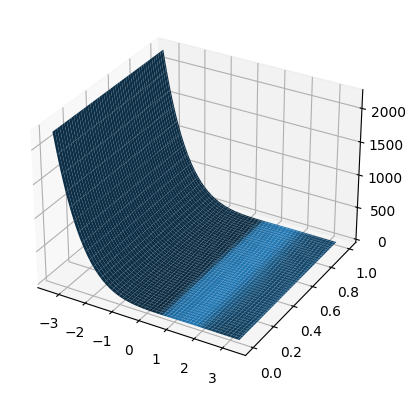


Train Epoch: 1 	Loss: 5519073.5000000000	Equation Loss: 225164.9843750000 	 BC Loss 5293908.500000
Right_boundary loss 5.4561347961	Left_boundary loss 4960142.0000000000	Up_boundary loss 333761.1250000000


Train Epoch: 1 	Loss: 5074526.5000000000	Equation Loss: 166147.6250000000 	 BC Loss 4908379.000000
Right_boundary loss 5.2861313820	Left_boundary loss 4599200.0000000000	Up_boundary loss 309173.2500000000


Train Epoch: 1 	Loss: 4729556.0000000000	Equation Loss: 186714.9062500000 	 BC Loss 4542841.000000
Right_boundary loss 5.1205458641	Left_boundary loss 4256964.0000000000	Up_boundary loss 285871.8437500000


Train Epoch: 1 	Loss: 4301517.0000000000	Equation Loss: 105173.3750000000 	 BC Loss 4196343.500000
Right_boundary loss 4.9605364799	Left_boundary loss 3932543.0000000000	Up_boundary loss 263795.3750000000

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 1, 	 Actual solution loss: 244729.7278523157


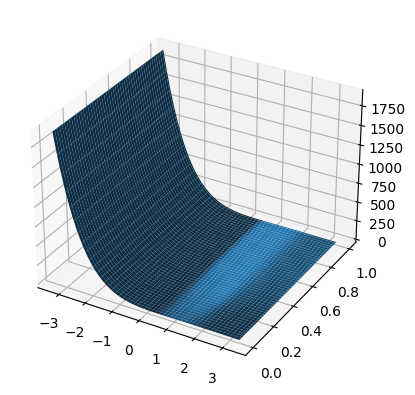


Train Epoch: 2 	Loss: 4054423.0000000000	Equation Loss: 154337.8750000000 	 BC Loss 3900085.000000
Right_boundary loss 4.8204841614	Left_boundary loss 3655150.5000000000	Up_boundary loss 244929.7812500000


Train Epoch: 2 	Loss: 3726650.7500000000	Equation Loss: 139096.1406250000 	 BC Loss 3587554.500000
Right_boundary loss 4.6684970856	Left_boundary loss 3362510.7500000000	Up_boundary loss 225038.9843750000


Train Epoch: 2 	Loss: 3371217.2500000000	Equation Loss: 79250.4375000000 	 BC Loss 3291966.750000
Right_boundary loss 4.5215902328	Left_boundary loss 3085723.7500000000	Up_boundary loss 206238.4375000000


Train Epoch: 2 	Loss: 3126518.0000000000	Equation Loss: 114122.0468750000 	 BC Loss 3012396.000000
Right_boundary loss 4.3785181046	Left_boundary loss 2823923.2500000000	Up_boundary loss 188468.1406250000

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 2, 	 Actual solution loss: 173179.1721196978



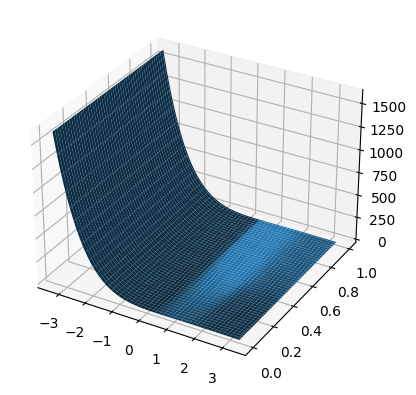


Train Epoch: 3 	Loss: 2890588.0000000000	Equation Loss: 116489.5078125000 	 BC Loss 2774098.500000
Right_boundary loss 4.2532162666	Left_boundary loss 2600762.5000000000	Up_boundary loss 173331.7187500000


Train Epoch: 3 	Loss: 2621465.0000000000	Equation Loss: 97600.2968750000 	 BC Loss 2523864.750000
Right_boundary loss 4.1176009178	Left_boundary loss 2366411.7500000000	Up_boundary loss 157449.0781250000


Train Epoch: 3 	Loss: 2376045.5000000000	Equation Loss: 88071.7812500000 	 BC Loss 2287973.750000
Right_boundary loss 3.9860799313	Left_boundary loss 2145480.7500000000	Up_boundary loss 142488.9062500000


Train Epoch: 3 	Loss: 2172184.0000000000	Equation Loss: 104747.4531250000 	 BC Loss 2067436.500000
Right_boundary loss 3.8585720062	Left_boundary loss 1938916.7500000000	Up_boundary loss 128515.8671875000

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 3, 	 Actual solution loss: 116608.1441126190



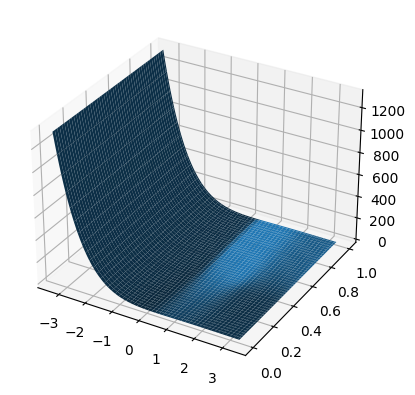


Train Epoch: 4 	Loss: 1954844.2500000000	Equation Loss: 73763.8359375000 	 BC Loss 1881080.375000
Right_boundary loss 3.7472326756	Left_boundary loss 1764356.5000000000	Up_boundary loss 116720.1171875000


Train Epoch: 4 	Loss: 1744842.2500000000	Equation Loss: 58198.5390625000 	 BC Loss 1686643.750000
Right_boundary loss 3.6267921925	Left_boundary loss 1582214.7500000000	Up_boundary loss 104425.3125000000


Train Epoch: 4 	Loss: 1572556.8750000000	Equation Loss: 67152.3359375000 	 BC Loss 1505404.500000
Right_boundary loss 3.5099163055	Left_boundary loss 1412422.1250000000	Up_boundary loss 92978.9375000000


Train Epoch: 4 	Loss: 1377010.5000000000	Equation Loss: 40730.7343750000 	 BC Loss 1336279.750000
Right_boundary loss 3.3964579105	Left_boundary loss 1253964.6250000000	Up_boundary loss 82311.8046875000

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 4, 	 Actual solution loss: 73340.5019600874



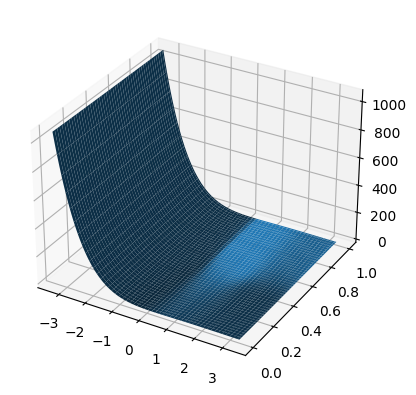


Train Epoch: 5 	Loss: 1262197.6250000000	Equation Loss: 67099.1718750000 	 BC Loss 1195098.500000
Right_boundary loss 3.2975797653	Left_boundary loss 1121675.5000000000	Up_boundary loss 73419.7343750000


Train Epoch: 5 	Loss: 1115313.7500000000	Equation Loss: 65468.0546875000 	 BC Loss 1049845.750000
Right_boundary loss 3.1912338734	Left_boundary loss 985557.1250000000	Up_boundary loss 64285.4296875000


Train Epoch: 5 	Loss: 941155.9375000000	Equation Loss: 25156.9394531250 	 BC Loss 915999.000000
Right_boundary loss 3.0880813599	Left_boundary loss 860112.1875000000	Up_boundary loss 55883.7343750000


Train Epoch: 5 	Loss: 824776.2500000000	Equation Loss: 31219.2187500000 	 BC Loss 793557.000000
Right_boundary loss 2.9886605740	Left_boundary loss 745340.1875000000	Up_boundary loss 48213.8046875000

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 5, 	 Actual solution loss: 41863.6320990681



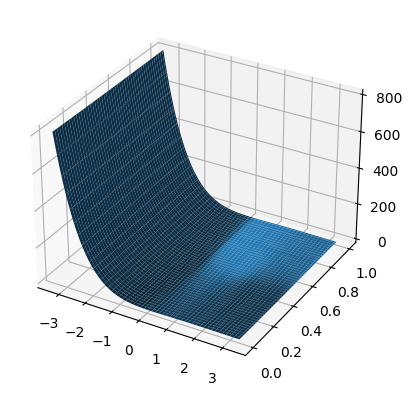


Train Epoch: 6 	Loss: 723060.3125000000	Equation Loss: 30261.7460937500 	 BC Loss 692798.562500
Right_boundary loss 2.9022967815	Left_boundary loss 650879.5000000000	Up_boundary loss 41916.1992187500


Train Epoch: 6 	Loss: 613198.5000000000	Equation Loss: 22216.1621093750 	 BC Loss 590982.312500
Right_boundary loss 2.8097410202	Left_boundary loss 555411.0000000000	Up_boundary loss 35568.5000000000


Train Epoch: 6 	Loss: 518930.8750000000	Equation Loss: 19675.4863281250 	 BC Loss 499255.375000
Right_boundary loss 2.7208335400	Left_boundary loss 469385.5625000000	Up_boundary loss 29867.0800781250


Train Epoch: 6 	Loss: 442335.1250000000	Equation Loss: 24813.8613281250 	 BC Loss 417521.250000
Right_boundary loss 2.6355881691	Left_boundary loss 392714.0000000000	Up_boundary loss 24804.6230468750

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 6, 	 Actual solution loss: 20713.3773039435



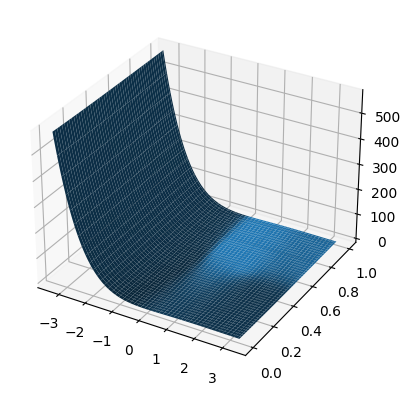


Train Epoch: 7 	Loss: 365220.5000000000	Equation Loss: 13495.7656250000 	 BC Loss 351724.718750
Right_boundary loss 2.5619590282	Left_boundary loss 330977.0937500000	Up_boundary loss 20745.0644531250


Train Epoch: 7 	Loss: 301923.2812500000	Equation Loss: 14758.4140625000 	 BC Loss 287164.875000
Right_boundary loss 2.4837112427	Left_boundary loss 270382.5000000000	Up_boundary loss 16779.9199218750


Train Epoch: 7 	Loss: 240856.2812500000	Equation Loss: 9671.1445312500 	 BC Loss 231185.140625
Right_boundary loss 2.4096350670	Left_boundary loss 217821.5468750000	Up_boundary loss 13361.1875000000


Train Epoch: 7 	Loss: 195364.9687500000	Equation Loss: 12366.8164062500 	 BC Loss 182998.156250
Right_boundary loss 2.3392014503	Left_boundary loss 172557.5000000000	Up_boundary loss 10438.3066406250

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 7, 	 Actual solution loss: 8197.2744535059



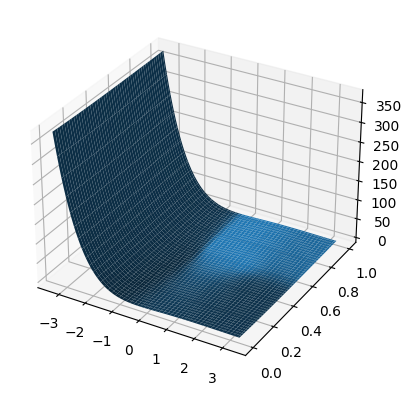


Train Epoch: 8 	Loss: 155784.2187500000	Equation Loss: 9758.2197265625 	 BC Loss 146026.000000
Right_boundary loss 2.2794713974	Left_boundary loss 137810.4062500000	Up_boundary loss 8213.3076171875


Train Epoch: 8 	Loss: 117488.7968750000	Equation Loss: 6039.6191406250 	 BC Loss 111449.179688
Right_boundary loss 2.2171356678	Left_boundary loss 105294.5625000000	Up_boundary loss 6152.3969726562


Train Epoch: 8 	Loss: 89748.6171875000	Equation Loss: 6629.6977539062 	 BC Loss 83118.921875
Right_boundary loss 2.1590859890	Left_boundary loss 78631.7812500000	Up_boundary loss 4484.9882812500


Train Epoch: 8 	Loss: 64750.5625000000	Equation Loss: 4469.8940429688 	 BC Loss 60280.667969
Right_boundary loss 2.1053264141	Left_boundary loss 57116.2304687500	Up_boundary loss 3162.3317871094

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 8, 	 Actual solution loss: 2232.1905582364



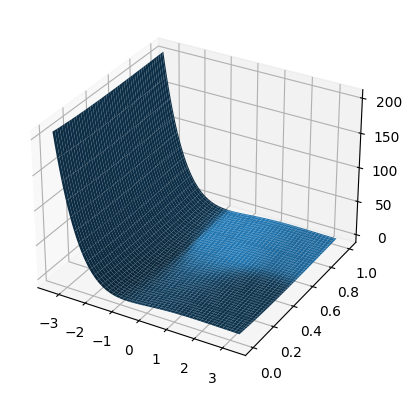


Train Epoch: 9 	Loss: 48985.1875000000	Equation Loss: 4994.7089843750 	 BC Loss 43990.476562
Right_boundary loss 2.0608682632	Left_boundary loss 41750.8007812500	Up_boundary loss 2237.6123046875


Train Epoch: 9 	Loss: 33063.0625000000	Equation Loss: 3066.8586425781 	 BC Loss 29996.203125
Right_boundary loss 2.0158929825	Left_boundary loss 28530.2832031250	Up_boundary loss 1463.9044189453


Train Epoch: 9 	Loss: 21550.5175781250	Equation Loss: 1915.9810791016 	 BC Loss 19634.537109
Right_boundary loss 1.9756282568	Left_boundary loss 18720.0957031250	Up_boundary loss 912.4654541016


Train Epoch: 9 	Loss: 14029.8593750000	Equation Loss: 1740.5628662109 	 BC Loss 12289.296875
Right_boundary loss 1.9403023720	Left_boundary loss 11744.9638671875	Up_boundary loss 542.3921508789

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 9, 	 Actual solution loss: 330.0598375341



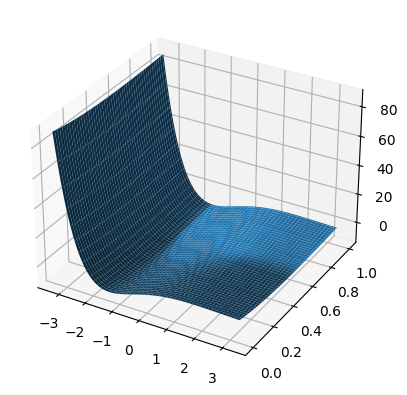


Train Epoch: 10 	Loss: 9038.4824218750	Equation Loss: 1323.4609375000 	 BC Loss 7715.021484
Right_boundary loss 1.9126424789	Left_boundary loss 7383.9111328125	Up_boundary loss 329.1979370117


Train Epoch: 10 	Loss: 5213.2119140625	Equation Loss: 874.4223022461 	 BC Loss 4338.789551
Right_boundary loss 1.8862956762	Left_boundary loss 4146.9414062500	Up_boundary loss 189.9617309570


Train Epoch: 10 	Loss: 3045.2133789062	Equation Loss: 748.6007080078 	 BC Loss 2296.612549
Right_boundary loss 1.8647036552	Left_boundary loss 2171.6230468750	Up_boundary loss 123.1247482300


Train Epoch: 10 	Loss: 1662.7858886719	Equation Loss: 516.8099975586 	 BC Loss 1145.975952
Right_boundary loss 1.8474518061	Left_boundary loss 1043.1087646484	Up_boundary loss 101.0197448730

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 10, 	 Actual solution loss: 106.0676493300



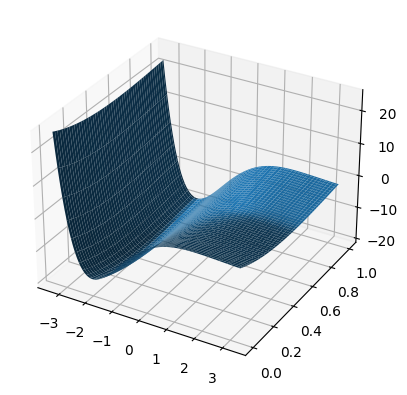


Train Epoch: 11 	Loss: 1168.5239257812	Equation Loss: 578.9159545898 	 BC Loss 589.607971
Right_boundary loss 1.8352094889	Left_boundary loss 485.2667846680	Up_boundary loss 102.5059890747


Train Epoch: 11 	Loss: 778.6832885742	Equation Loss: 480.8108520508 	 BC Loss 297.872437
Right_boundary loss 1.8250911236	Left_boundary loss 181.2180480957	Up_boundary loss 114.8292999268


Train Epoch: 11 	Loss: 671.5373535156	Equation Loss: 484.3159790039 	 BC Loss 187.221375
Right_boundary loss 1.8180441856	Left_boundary loss 56.0248260498	Up_boundary loss 129.3785095215


Train Epoch: 11 	Loss: 594.8905029297	Equation Loss: 438.6435852051 	 BC Loss 156.246887
Right_boundary loss 1.8134829998	Left_boundary loss 12.7693567276	Up_boundary loss 141.6640472412

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 11, 	 Actual solution loss: 153.3755204802



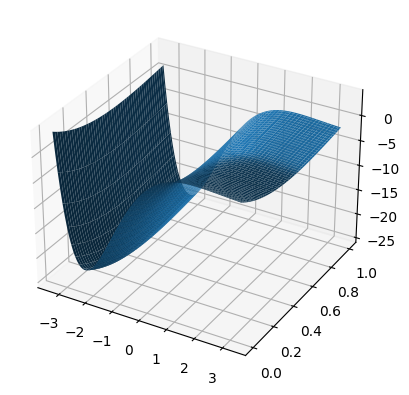


Train Epoch: 12 	Loss: 576.8739013672	Equation Loss: 423.2006225586 	 BC Loss 153.673279
Right_boundary loss 1.8109841347	Left_boundary loss 2.4256112576	Up_boundary loss 149.4366760254


Train Epoch: 12 	Loss: 511.2326049805	Equation Loss: 353.6209411621 	 BC Loss 157.611649
Right_boundary loss 1.8095279932	Left_boundary loss 1.1414173841	Up_boundary loss 154.6607055664


Train Epoch: 12 	Loss: 542.0569458008	Equation Loss: 381.9364624023 	 BC Loss 160.120499
Right_boundary loss 1.8090995550	Left_boundary loss 1.7895709276	Up_boundary loss 156.5218353271


Train Epoch: 12 	Loss: 626.6093139648	Equation Loss: 464.1594543457 	 BC Loss 162.449844
Right_boundary loss 1.8088744879	Left_boundary loss 2.7574350834	Up_boundary loss 157.8835296631

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 12, 	 Actual solution loss: 161.7011604962



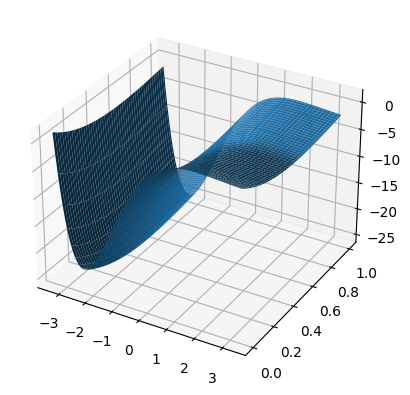


Train Epoch: 13 	Loss: 462.2982177734	Equation Loss: 298.8805541992 	 BC Loss 163.417664
Right_boundary loss 1.8090348244	Left_boundary loss 3.3292682171	Up_boundary loss 158.2793579102


Train Epoch: 13 	Loss: 477.3943481445	Equation Loss: 314.9911193848 	 BC Loss 162.403214
Right_boundary loss 1.8094799519	Left_boundary loss 3.1179058552	Up_boundary loss 157.4758300781


Train Epoch: 13 	Loss: 562.4359741211	Equation Loss: 401.2128295898 	 BC Loss 161.223145
Right_boundary loss 1.8100028038	Left_boundary loss 2.8658628464	Up_boundary loss 156.5472717285


Train Epoch: 13 	Loss: 669.3636474609	Equation Loss: 508.9070739746 	 BC Loss 160.456543
Right_boundary loss 1.8105187416	Left_boundary loss 2.8127105236	Up_boundary loss 155.8333129883

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 13, 	 Actual solution loss: 158.3525128415



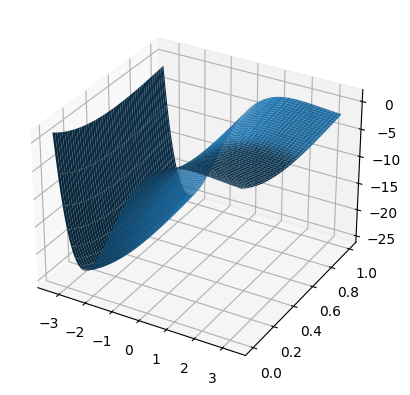


Train Epoch: 14 	Loss: 460.5090942383	Equation Loss: 299.8371582031 	 BC Loss 160.671936
Right_boundary loss 1.8108233213	Left_boundary loss 3.1719992161	Up_boundary loss 155.6891174316


Train Epoch: 14 	Loss: 548.0374755859	Equation Loss: 387.3864746094 	 BC Loss 160.651031
Right_boundary loss 1.8113781214	Left_boundary loss 3.5047824383	Up_boundary loss 155.3348693848


Train Epoch: 14 	Loss: 399.2906188965	Equation Loss: 241.1509857178 	 BC Loss 158.139633
Right_boundary loss 1.8122832775	Left_boundary loss 2.7963452339	Up_boundary loss 153.5310058594


Train Epoch: 14 	Loss: 557.7583007812	Equation Loss: 401.1290283203 	 BC Loss 156.629303
Right_boundary loss 1.8130952120	Left_boundary loss 2.5770146847	Up_boundary loss 152.2391967773

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 14, 	 Actual solution loss: 153.1311589782



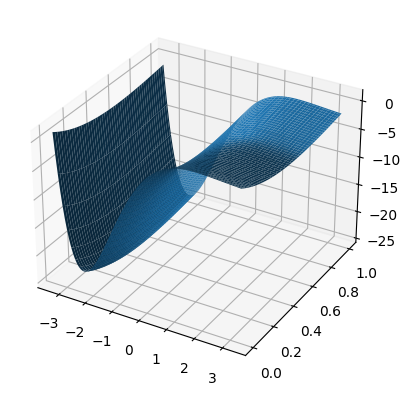


Train Epoch: 15 	Loss: 478.4752197266	Equation Loss: 322.6538391113 	 BC Loss 155.821365
Right_boundary loss 1.8137488365	Left_boundary loss 2.6230447292	Up_boundary loss 151.3845672607


Train Epoch: 15 	Loss: 631.2041015625	Equation Loss: 476.1346130371 	 BC Loss 155.069473
Right_boundary loss 1.8145515919	Left_boundary loss 2.7817106247	Up_boundary loss 150.4732055664


Train Epoch: 15 	Loss: 483.0043334961	Equation Loss: 328.0014343262 	 BC Loss 155.002884
Right_boundary loss 1.8154077530	Left_boundary loss 3.3075187206	Up_boundary loss 149.8799591064


Train Epoch: 15 	Loss: 726.4510498047	Equation Loss: 575.7737426758 	 BC Loss 150.677307
Right_boundary loss 1.8168841600	Left_boundary loss 2.0808734894	Up_boundary loss 146.7795562744

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 15, 	 Actual solution loss: 147.2266358162



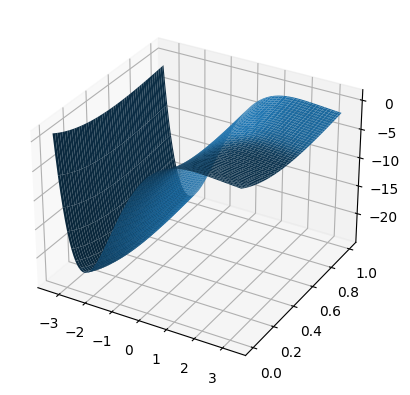


Train Epoch: 16 	Loss: 423.4873657227	Equation Loss: 272.2430725098 	 BC Loss 151.244293
Right_boundary loss 1.8175867796	Left_boundary loss 2.8618414402	Up_boundary loss 146.5648651123


Train Epoch: 16 	Loss: 447.3755187988	Equation Loss: 296.8996582031 	 BC Loss 150.475861
Right_boundary loss 1.8187977076	Left_boundary loss 3.2589173317	Up_boundary loss 145.3981475830


Train Epoch: 16 	Loss: 495.4429931641	Equation Loss: 349.0453796387 	 BC Loss 146.397598
Right_boundary loss 1.8206486702	Left_boundary loss 2.2881298065	Up_boundary loss 142.2888183594


Train Epoch: 16 	Loss: 398.7362365723	Equation Loss: 254.9750823975 	 BC Loss 143.761154
Right_boundary loss 1.8222556114	Left_boundary loss 2.0271086693	Up_boundary loss 139.9117889404

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 16, 	 Actual solution loss: 138.1936212859



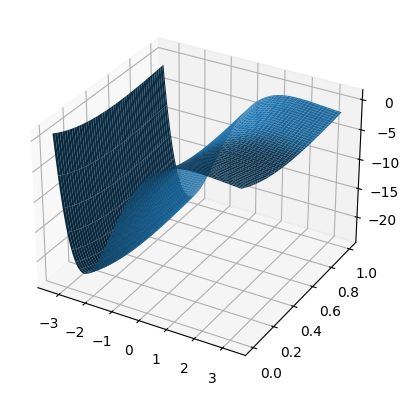


Train Epoch: 17 	Loss: 420.7670898438	Equation Loss: 277.8273315430 	 BC Loss 142.939758
Right_boundary loss 1.8234311342	Left_boundary loss 2.4615752697	Up_boundary loss 138.6547546387


Train Epoch: 17 	Loss: 401.7577209473	Equation Loss: 260.4131469727 	 BC Loss 141.344574
Right_boundary loss 1.8251911402	Left_boundary loss 2.7781593800	Up_boundary loss 136.7412261963


Train Epoch: 17 	Loss: 385.3343811035	Equation Loss: 248.8632354736 	 BC Loss 136.471146
Right_boundary loss 1.8276274204	Left_boundary loss 1.8031002283	Up_boundary loss 132.8404235840


Train Epoch: 17 	Loss: 522.0531616211	Equation Loss: 385.8280029297 	 BC Loss 136.225174
Right_boundary loss 1.8292540312	Left_boundary loss 2.8251121044	Up_boundary loss 131.5708007812

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 17, 	 Actual solution loss: 127.0940035199



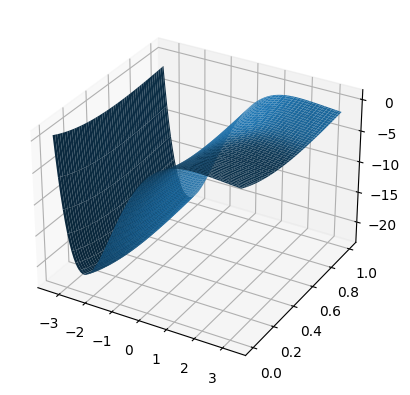


Train Epoch: 18 	Loss: 331.4596252441	Equation Loss: 198.2483978271 	 BC Loss 133.211227
Right_boundary loss 1.8318082094	Left_boundary loss 2.6765630245	Up_boundary loss 128.7028503418


Train Epoch: 18 	Loss: 519.3538818359	Equation Loss: 390.2593078613 	 BC Loss 129.094574
Right_boundary loss 1.8349151611	Left_boundary loss 2.2720685005	Up_boundary loss 124.9875869751


Train Epoch: 18 	Loss: 471.7817382812	Equation Loss: 347.0108337402 	 BC Loss 124.770897
Right_boundary loss 1.8383064270	Left_boundary loss 1.8770401478	Up_boundary loss 121.0555496216


Train Epoch: 18 	Loss: 467.1570434570	Equation Loss: 346.8717041016 	 BC Loss 120.285347
Right_boundary loss 1.8418065310	Left_boundary loss 1.5162460804	Up_boundary loss 116.9272918701

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 18, 	 Actual solution loss: 111.0072348667



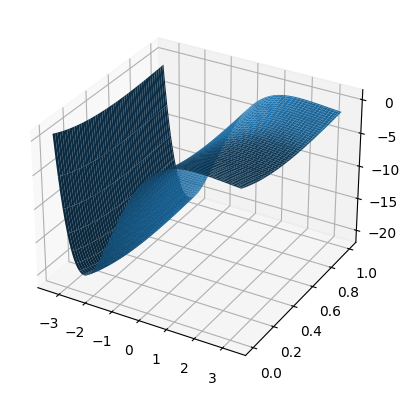


Train Epoch: 19 	Loss: 304.6856079102	Equation Loss: 187.6303710938 	 BC Loss 117.055252
Right_boundary loss 1.8450903893	Left_boundary loss 1.5834333897	Up_boundary loss 113.6267318726


Train Epoch: 19 	Loss: 448.1470642090	Equation Loss: 337.3943786621 	 BC Loss 110.752693
Right_boundary loss 1.8497445583	Left_boundary loss 0.7902958393	Up_boundary loss 108.1126556396


Train Epoch: 19 	Loss: 369.3333129883	Equation Loss: 257.6373596191 	 BC Loss 111.695961
Right_boundary loss 1.8533244133	Left_boundary loss 2.8720395565	Up_boundary loss 106.9705963135


Train Epoch: 19 	Loss: 297.8435668945	Equation Loss: 192.1055908203 	 BC Loss 105.737961
Right_boundary loss 1.8588835001	Left_boundary loss 2.1801073551	Up_boundary loss 101.6989669800

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 19, 	 Actual solution loss: 92.7423284276



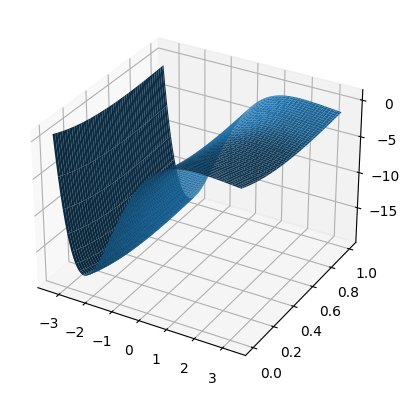


Train Epoch: 20 	Loss: 408.9630737305	Equation Loss: 309.7784729004 	 BC Loss 99.184586
Right_boundary loss 1.8648610115	Left_boundary loss 1.1969968081	Up_boundary loss 96.1227264404


Train Epoch: 20 	Loss: 318.5749816895	Equation Loss: 220.0530242920 	 BC Loss 98.521950
Right_boundary loss 1.8707066774	Left_boundary loss 3.0967528820	Up_boundary loss 93.5544891357


Train Epoch: 20 	Loss: 231.2135772705	Equation Loss: 139.9842834473 	 BC Loss 91.229294
Right_boundary loss 1.8794246912	Left_boundary loss 2.0601522923	Up_boundary loss 87.2897186279


Train Epoch: 20 	Loss: 343.9740905762	Equation Loss: 262.4970703125 	 BC Loss 81.477028
Right_boundary loss 1.8889259100	Left_boundary loss 0.3540072739	Up_boundary loss 79.2340927124

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 20, 	 Actual solution loss: 72.7589866724



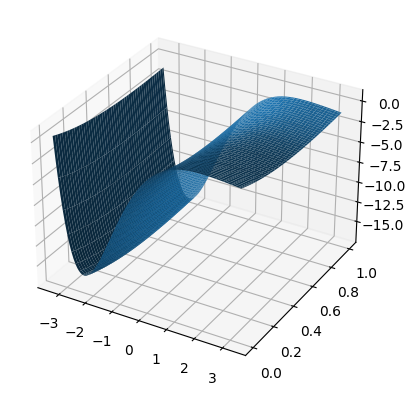


Train Epoch: 21 	Loss: 252.9567108154	Equation Loss: 173.3427734375 	 BC Loss 79.613937
Right_boundary loss 1.8958801031	Left_boundary loss 1.1499210596	Up_boundary loss 76.5681381226


Train Epoch: 21 	Loss: 230.0993194580	Equation Loss: 156.1968688965 	 BC Loss 73.902451
Right_boundary loss 1.9057512283	Left_boundary loss 0.9103506207	Up_boundary loss 71.0863494873


Train Epoch: 21 	Loss: 180.6688079834	Equation Loss: 111.1782989502 	 BC Loss 69.490509
Right_boundary loss 1.9173409939	Left_boundary loss 1.2837891579	Up_boundary loss 66.2893753052


Train Epoch: 21 	Loss: 193.1322326660	Equation Loss: 127.6519012451 	 BC Loss 65.480339
Right_boundary loss 1.9303811789	Left_boundary loss 1.9145464897	Up_boundary loss 61.6354141235

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 21, 	 Actual solution loss: 52.0290720566



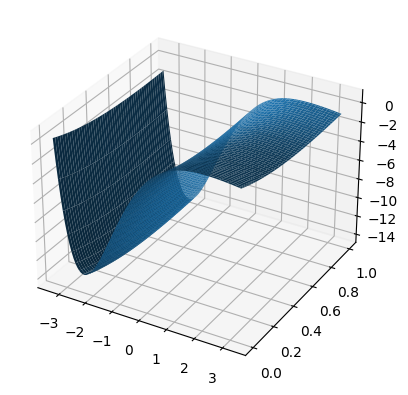


Train Epoch: 22 	Loss: 181.3920135498	Equation Loss: 122.6835327148 	 BC Loss 58.708485
Right_boundary loss 1.9451156855	Left_boundary loss 1.0100591183	Up_boundary loss 55.7533111572


Train Epoch: 22 	Loss: 203.9990234375	Equation Loss: 150.8827667236 	 BC Loss 53.116249
Right_boundary loss 1.9608273506	Left_boundary loss 0.8126291037	Up_boundary loss 50.3427925110


Train Epoch: 22 	Loss: 195.4562988281	Equation Loss: 146.8473663330 	 BC Loss 48.608925
Right_boundary loss 1.9799666405	Left_boundary loss 1.1267895699	Up_boundary loss 45.5021667480


Train Epoch: 22 	Loss: 126.7773590088	Equation Loss: 83.6525878906 	 BC Loss 43.124767
Right_boundary loss 1.9988679886	Left_boundary loss 0.8124672174	Up_boundary loss 40.3134307861

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 22, 	 Actual solution loss: 32.1854642722



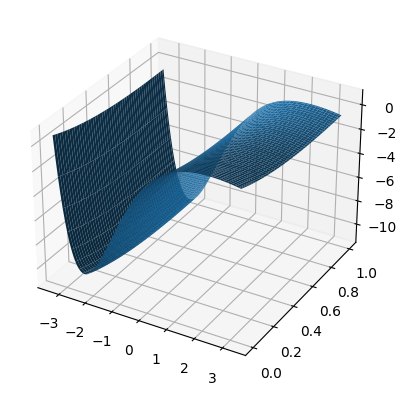


Train Epoch: 23 	Loss: 122.6324539185	Equation Loss: 85.0351333618 	 BC Loss 37.597321
Right_boundary loss 2.0169239044	Left_boundary loss 0.2692056000	Up_boundary loss 35.3111915588


Train Epoch: 23 	Loss: 97.8017883301	Equation Loss: 65.1690063477 	 BC Loss 32.632782
Right_boundary loss 2.0383958817	Left_boundary loss 0.1413355470	Up_boundary loss 30.4530487061


Train Epoch: 23 	Loss: 68.0146179199	Equation Loss: 38.1197052002 	 BC Loss 29.894917
Right_boundary loss 2.0582785606	Left_boundary loss 0.4861885905	Up_boundary loss 27.3504486084


Train Epoch: 23 	Loss: 73.6664810181	Equation Loss: 47.4613227844 	 BC Loss 26.205156
Right_boundary loss 2.0790369511	Left_boundary loss 0.4902735054	Up_boundary loss 23.6358451843

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 23, 	 Actual solution loss: 18.3069757096



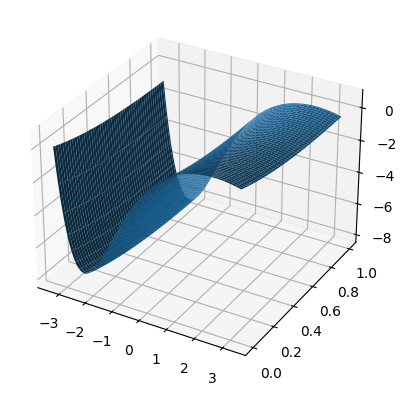


Train Epoch: 24 	Loss: 60.2155838013	Equation Loss: 36.8655929565 	 BC Loss 23.349991
Right_boundary loss 2.0991234779	Left_boundary loss 0.6303486824	Up_boundary loss 20.6205177307


Train Epoch: 24 	Loss: 36.8931350708	Equation Loss: 17.3394737244 	 BC Loss 19.553659
Right_boundary loss 2.1214025021	Left_boundary loss 0.3160688877	Up_boundary loss 17.1161880493


Train Epoch: 24 	Loss: 28.0005531311	Equation Loss: 11.8569240570 	 BC Loss 16.143629
Right_boundary loss 2.1431298256	Left_boundary loss 0.0897383690	Up_boundary loss 13.9107608795


Train Epoch: 24 	Loss: 36.6722869873	Equation Loss: 22.6030464172 	 BC Loss 14.069241
Right_boundary loss 2.1617696285	Left_boundary loss 0.1963033676	Up_boundary loss 11.7111673355

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 24, 	 Actual solution loss: 8.0733524813



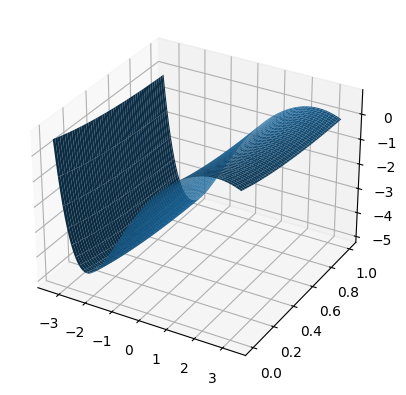


Train Epoch: 25 	Loss: 20.4909667969	Equation Loss: 8.8451461792 	 BC Loss 11.645820
Right_boundary loss 2.1777288914	Left_boundary loss 0.0493706092	Up_boundary loss 9.4187202454


Train Epoch: 25 	Loss: 18.9476394653	Equation Loss: 8.9591875076 	 BC Loss 9.988451
Right_boundary loss 2.1895940304	Left_boundary loss 0.0330082625	Up_boundary loss 7.7658491135


Train Epoch: 25 	Loss: 17.4361991882	Equation Loss: 8.5176324844 	 BC Loss 8.918568
Right_boundary loss 2.1974172592	Left_boundary loss 0.1586110592	Up_boundary loss 6.5625391006


Train Epoch: 25 	Loss: 11.7797803879	Equation Loss: 4.3343601227 	 BC Loss 7.445420
Right_boundary loss 2.2056469917	Left_boundary loss 0.0584287420	Up_boundary loss 5.1813445091

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 25, 	 Actual solution loss: 3.5444299549



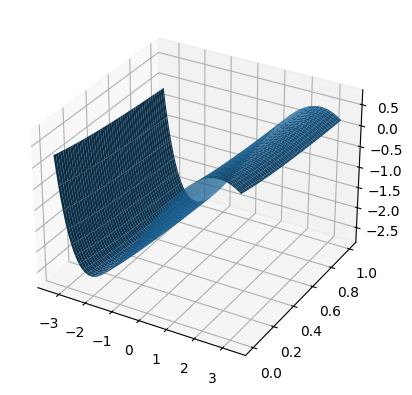


Train Epoch: 26 	Loss: 7.8302073479	Equation Loss: 1.4525465965 	 BC Loss 6.377661
Right_boundary loss 2.2092306614	Left_boundary loss 0.0124563910	Up_boundary loss 4.1559739113


Train Epoch: 26 	Loss: 6.9866476059	Equation Loss: 1.2810654640 	 BC Loss 5.705582
Right_boundary loss 2.2056367397	Left_boundary loss 0.0526820906	Up_boundary loss 3.4472632408


Train Epoch: 26 	Loss: 6.2444529533	Equation Loss: 1.3014336824 	 BC Loss 4.943019
Right_boundary loss 2.1965939999	Left_boundary loss 0.0146276327	Up_boundary loss 2.7317976952


Train Epoch: 26 	Loss: 4.8452281952	Equation Loss: 0.3825389743 	 BC Loss 4.462689
Right_boundary loss 2.1814239025	Left_boundary loss 0.0025405905	Up_boundary loss 2.2787249088

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 26, 	 Actual solution loss: 1.8077402974



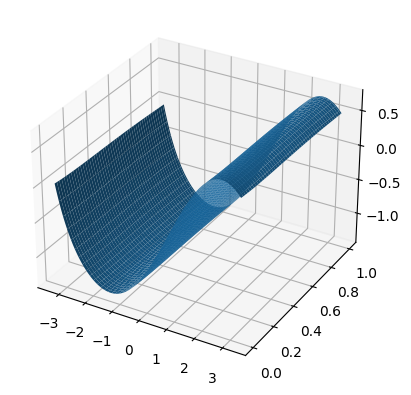


Train Epoch: 27 	Loss: 4.2893271446	Equation Loss: 0.1627810299 	 BC Loss 4.126546
Right_boundary loss 2.1616737843	Left_boundary loss 0.0006047562	Up_boundary loss 1.9642670155


Train Epoch: 27 	Loss: 3.9185407162	Equation Loss: 0.0998613834 	 BC Loss 3.818679
Right_boundary loss 2.1329789162	Left_boundary loss 0.0000376175	Up_boundary loss 1.6856628656


Train Epoch: 27 	Loss: 3.6086826324	Equation Loss: 0.0348122865 	 BC Loss 3.573870
Right_boundary loss 2.0972440243	Left_boundary loss 0.0005852800	Up_boundary loss 1.4760410786


Train Epoch: 27 	Loss: 3.3936824799	Equation Loss: 0.0307790507 	 BC Loss 3.362903
Right_boundary loss 2.0553941727	Left_boundary loss 0.0025746368	Up_boundary loss 1.3049345016

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 27, 	 Actual solution loss: 1.2626355491



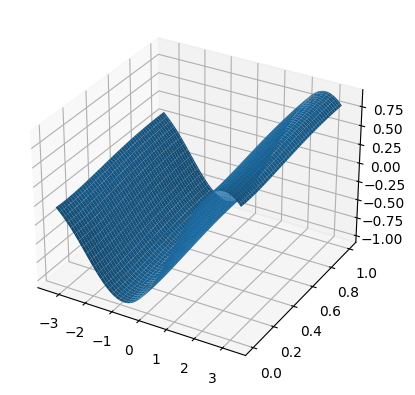


Train Epoch: 28 	Loss: 3.2425820827	Equation Loss: 0.0432121530 	 BC Loss 3.199370
Right_boundary loss 2.0127618313	Left_boundary loss 0.0031038420	Up_boundary loss 1.1835043430


Train Epoch: 28 	Loss: 3.0912296772	Equation Loss: 0.0567083135 	 BC Loss 3.034521
Right_boundary loss 1.9606845379	Left_boundary loss 0.0041750558	Up_boundary loss 1.0696617365


Train Epoch: 28 	Loss: 2.9495737553	Equation Loss: 0.0690109953 	 BC Loss 2.880563
Right_boundary loss 1.9044433832	Left_boundary loss 0.0053893561	Up_boundary loss 0.9707301855


Train Epoch: 28 	Loss: 2.8059694767	Equation Loss: 0.0715797618 	 BC Loss 2.734390
Right_boundary loss 1.8442341089	Left_boundary loss 0.0066099288	Up_boundary loss 0.8835456967

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 28, 	 Actual solution loss: 0.9688518785



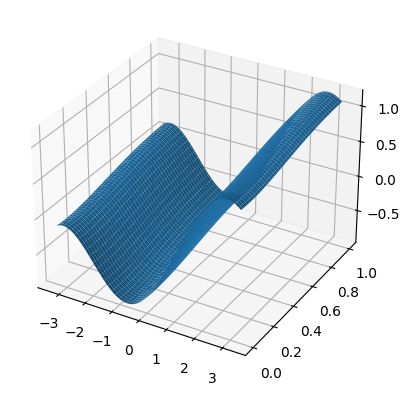


Train Epoch: 29 	Loss: 2.6989727020	Equation Loss: 0.0910694078 	 BC Loss 2.607903
Right_boundary loss 1.7870299816	Left_boundary loss 0.0076166759	Up_boundary loss 0.8132566810


Train Epoch: 29 	Loss: 2.5537040234	Equation Loss: 0.0817449540 	 BC Loss 2.471959
Right_boundary loss 1.7202595472	Left_boundary loss 0.0082103834	Up_boundary loss 0.7434890866


Train Epoch: 29 	Loss: 2.4241065979	Equation Loss: 0.0857804194 	 BC Loss 2.338326
Right_boundary loss 1.6503205299	Left_boundary loss 0.0087018339	Up_boundary loss 0.6793038845


Train Epoch: 29 	Loss: 2.3082215786	Equation Loss: 0.1000644490 	 BC Loss 2.208157
Right_boundary loss 1.5776721239	Left_boundary loss 0.0091257850	Up_boundary loss 0.6213591695

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 29, 	 Actual solution loss: 0.7100681710



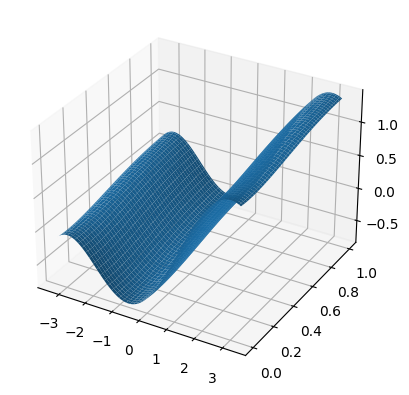


Train Epoch: 30 	Loss: 2.1898837090	Equation Loss: 0.0973542929 	 BC Loss 2.092530
Right_boundary loss 1.5105662346	Left_boundary loss 0.0086026499	Up_boundary loss 0.5733606815


Train Epoch: 30 	Loss: 2.0336656570	Equation Loss: 0.0688358322 	 BC Loss 1.964830
Right_boundary loss 1.4338099957	Left_boundary loss 0.0085099954	Up_boundary loss 0.5225098133


Train Epoch: 30 	Loss: 1.9191801548	Equation Loss: 0.0800344795 	 BC Loss 1.839146
Right_boundary loss 1.3558000326	Left_boundary loss 0.0093512926	Up_boundary loss 0.4739943743


Train Epoch: 30 	Loss: 1.7928328514	Equation Loss: 0.0793395862 	 BC Loss 1.713493
Right_boundary loss 1.2767691612	Left_boundary loss 0.0076597203	Up_boundary loss 0.4290643930

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 30, 	 Actual solution loss: 0.4785779655



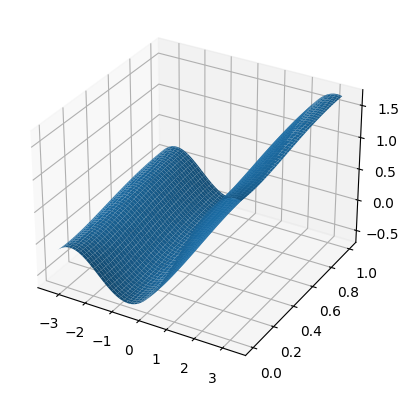


Train Epoch: 31 	Loss: 1.6765437126	Equation Loss: 0.0744585022 	 BC Loss 1.602085
Right_boundary loss 1.2050156593	Left_boundary loss 0.0081416424	Up_boundary loss 0.3889279664


Train Epoch: 31 	Loss: 1.5707309246	Equation Loss: 0.0634676516 	 BC Loss 1.507263
Right_boundary loss 1.1251775026	Left_boundary loss 0.0354586877	Up_boundary loss 0.3466271162


Train Epoch: 31 	Loss: 1.4330717325	Equation Loss: 0.0670309961 	 BC Loss 1.366041
Right_boundary loss 1.0480542183	Left_boundary loss 0.0087542739	Up_boundary loss 0.3092322052


Train Epoch: 31 	Loss: 1.3167712688	Equation Loss: 0.0586170927 	 BC Loss 1.258154
Right_boundary loss 0.9726590514	Left_boundary loss 0.0117304353	Up_boundary loss 0.2737646401

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 31, 	 Actual solution loss: 0.2875275138



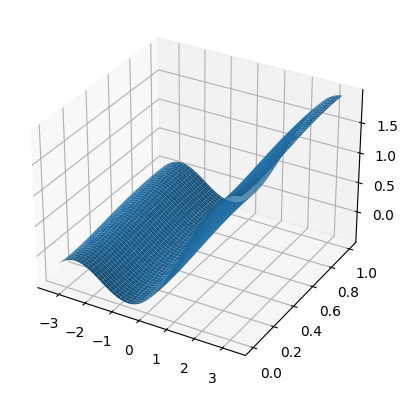


Train Epoch: 32 	Loss: 1.2108733654	Equation Loss: 0.0463264026 	 BC Loss 1.164547
Right_boundary loss 0.9079257250	Left_boundary loss 0.0127283884	Up_boundary loss 0.2438928038


Train Epoch: 32 	Loss: 1.1575801373	Equation Loss: 0.0437299684 	 BC Loss 1.113850
Right_boundary loss 0.8383755684	Left_boundary loss 0.0523804277	Up_boundary loss 0.2230941653


Train Epoch: 32 	Loss: 1.0073002577	Equation Loss: 0.0383583345 	 BC Loss 0.968942
Right_boundary loss 0.7727957964	Left_boundary loss 0.0108934650	Up_boundary loss 0.1852526665


Train Epoch: 32 	Loss: 0.9310422540	Equation Loss: 0.0459986851 	 BC Loss 0.885044
Right_boundary loss 0.7095867395	Left_boundary loss 0.0148639586	Up_boundary loss 0.1605928540

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 32, 	 Actual solution loss: 0.1578019139



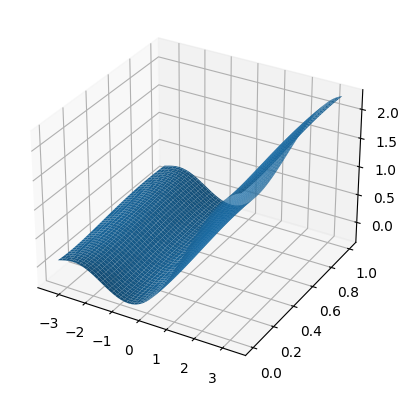


Train Epoch: 33 	Loss: 0.8628645539	Equation Loss: 0.0362212807 	 BC Loss 0.826643
Right_boundary loss 0.6577324867	Left_boundary loss 0.0211057886	Up_boundary loss 0.1478050351


Train Epoch: 33 	Loss: 0.7717402577	Equation Loss: 0.0308815017 	 BC Loss 0.740859
Right_boundary loss 0.6038302779	Left_boundary loss 0.0118839927	Up_boundary loss 0.1251444966


Train Epoch: 33 	Loss: 0.6871980429	Equation Loss: 0.0280108023 	 BC Loss 0.659187
Right_boundary loss 0.5517020226	Left_boundary loss 0.0033722394	Up_boundary loss 0.1041129753


Train Epoch: 33 	Loss: 0.6328411102	Equation Loss: 0.0337246731 	 BC Loss 0.599116
Right_boundary loss 0.5026381612	Left_boundary loss 0.0092107579	Up_boundary loss 0.0872675106

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 33, 	 Actual solution loss: 0.0800160309



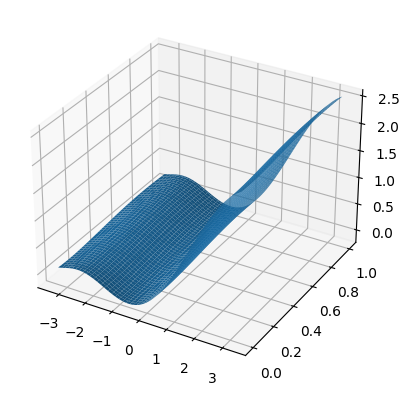


Train Epoch: 34 	Loss: 0.6004596353	Equation Loss: 0.0342046246 	 BC Loss 0.566255
Right_boundary loss 0.4619790614	Left_boundary loss 0.0223536417	Up_boundary loss 0.0819223300


Train Epoch: 34 	Loss: 0.5255240202	Equation Loss: 0.0290689785 	 BC Loss 0.496455
Right_boundary loss 0.4200062454	Left_boundary loss 0.0128877535	Up_boundary loss 0.0635610297


Train Epoch: 34 	Loss: 0.4806038141	Equation Loss: 0.0280638747 	 BC Loss 0.452540
Right_boundary loss 0.3805122674	Left_boundary loss 0.0184355658	Up_boundary loss 0.0535921231


Train Epoch: 34 	Loss: 0.4513878822	Equation Loss: 0.0329277366 	 BC Loss 0.418460
Right_boundary loss 0.3443511724	Left_boundary loss 0.0210543536	Up_boundary loss 0.0530546233

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 34, 	 Actual solution loss: 0.0363206070



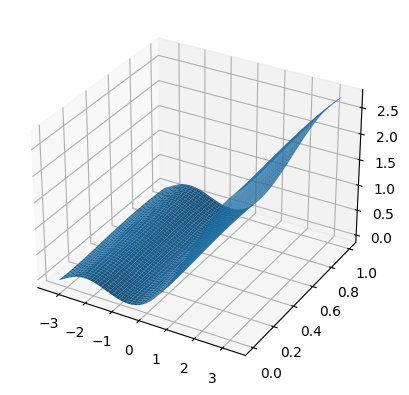


Train Epoch: 35 	Loss: 0.3855580688	Equation Loss: 0.0285571925 	 BC Loss 0.357001
Right_boundary loss 0.3144728839	Left_boundary loss 0.0012758541	Up_boundary loss 0.0412521362


Train Epoch: 35 	Loss: 0.4813233018	Equation Loss: 0.0417823307 	 BC Loss 0.439541
Right_boundary loss 0.2836626768	Left_boundary loss 0.1039451435	Up_boundary loss 0.0519331731


Train Epoch: 35 	Loss: 0.3405302763	Equation Loss: 0.0416373760 	 BC Loss 0.298893
Right_boundary loss 0.2581667602	Left_boundary loss 0.0070730913	Up_boundary loss 0.0336530432


Train Epoch: 35 	Loss: 0.3202963471	Equation Loss: 0.0238354839 	 BC Loss 0.296461
Right_boundary loss 0.2343242317	Left_boundary loss 0.0372873545	Up_boundary loss 0.0248492956

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 35, 	 Actual solution loss: 0.0200735815



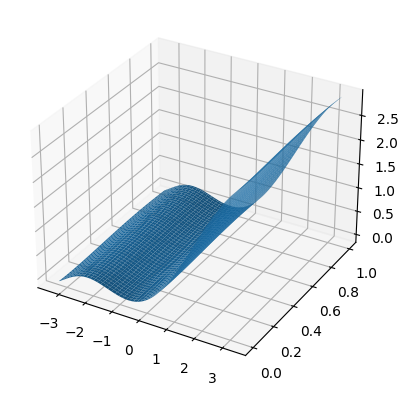


Train Epoch: 36 	Loss: 0.2636505663	Equation Loss: 0.0200786404 	 BC Loss 0.243572
Right_boundary loss 0.2142520398	Left_boundary loss 0.0056969202	Up_boundary loss 0.0236229561


Train Epoch: 36 	Loss: 0.2452944964	Equation Loss: 0.0279784203 	 BC Loss 0.217316
Right_boundary loss 0.1930224597	Left_boundary loss 0.0034195045	Up_boundary loss 0.0208741073


Train Epoch: 36 	Loss: 0.2183698863	Equation Loss: 0.0241536498 	 BC Loss 0.194216
Right_boundary loss 0.1730795503	Left_boundary loss 0.0006210750	Up_boundary loss 0.0205156058


Train Epoch: 36 	Loss: 0.2138155103	Equation Loss: 0.0264109578 	 BC Loss 0.187405
Right_boundary loss 0.1546494365	Left_boundary loss 0.0105784368	Up_boundary loss 0.0221766848

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 36, 	 Actual solution loss: 0.0138066392



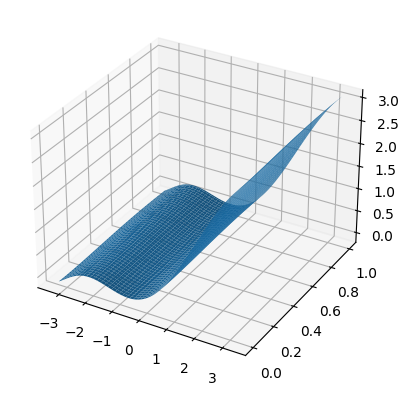


Train Epoch: 37 	Loss: 0.1919649541	Equation Loss: 0.0204482451 	 BC Loss 0.171517
Right_boundary loss 0.1405343562	Left_boundary loss 0.0163169764	Up_boundary loss 0.0146653820


Train Epoch: 37 	Loss: 0.1781278849	Equation Loss: 0.0236425772 	 BC Loss 0.154485
Right_boundary loss 0.1268192530	Left_boundary loss 0.0084202923	Up_boundary loss 0.0192457587


Train Epoch: 37 	Loss: 0.1522161961	Equation Loss: 0.0223052241 	 BC Loss 0.129911
Right_boundary loss 0.1138757318	Left_boundary loss 0.0002963800	Up_boundary loss 0.0157388672


Train Epoch: 37 	Loss: 0.1607393920	Equation Loss: 0.0208561346 	 BC Loss 0.139883
Right_boundary loss 0.1018339619	Left_boundary loss 0.0184056349	Up_boundary loss 0.0196436532

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 37, 	 Actual solution loss: 0.0133547385



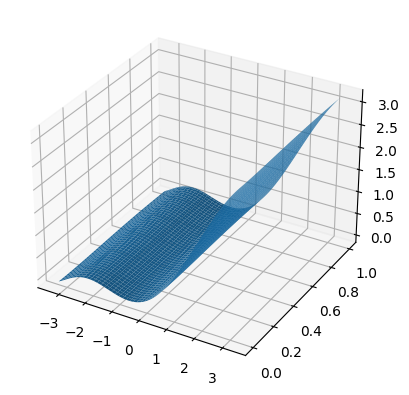


Train Epoch: 38 	Loss: 0.1323144883	Equation Loss: 0.0212950706 	 BC Loss 0.111019
Right_boundary loss 0.0920960978	Left_boundary loss 0.0070773731	Up_boundary loss 0.0118459500


Train Epoch: 38 	Loss: 0.1182437539	Equation Loss: 0.0224682875 	 BC Loss 0.095775
Right_boundary loss 0.0820913985	Left_boundary loss 0.0016192745	Up_boundary loss 0.0120647931


Train Epoch: 38 	Loss: 0.1896668971	Equation Loss: 0.0243386049 	 BC Loss 0.165328
Right_boundary loss 0.0728314444	Left_boundary loss 0.0681724101	Up_boundary loss 0.0243244506


Train Epoch: 38 	Loss: 0.0990906656	Equation Loss: 0.0161331259 	 BC Loss 0.082958
Right_boundary loss 0.0649366528	Left_boundary loss 0.0068713236	Up_boundary loss 0.0111495694

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 38, 	 Actual solution loss: 0.0137090118



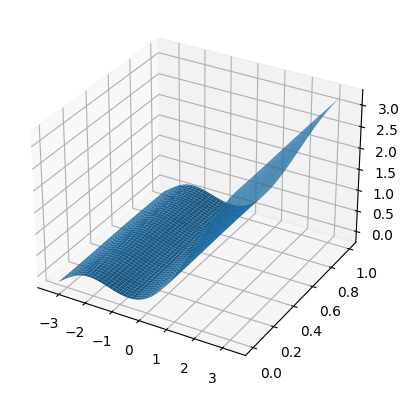


Train Epoch: 39 	Loss: 0.1151703000	Equation Loss: 0.0157374777 	 BC Loss 0.099433
Right_boundary loss 0.0586763397	Left_boundary loss 0.0306613874	Up_boundary loss 0.0100950990


Train Epoch: 39 	Loss: 0.0822558850	Equation Loss: 0.0157586373 	 BC Loss 0.066497
Right_boundary loss 0.0523516983	Left_boundary loss 0.0023564650	Up_boundary loss 0.0117890825


Train Epoch: 39 	Loss: 0.1394442469	Equation Loss: 0.0198909510 	 BC Loss 0.119553
Right_boundary loss 0.0463394821	Left_boundary loss 0.0634761453	Up_boundary loss 0.0097376611


Train Epoch: 39 	Loss: 0.0841138661	Equation Loss: 0.0174683668 	 BC Loss 0.066646
Right_boundary loss 0.0411501080	Left_boundary loss 0.0147695420	Up_boundary loss 0.0107258502

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 39, 	 Actual solution loss: 0.0158555115



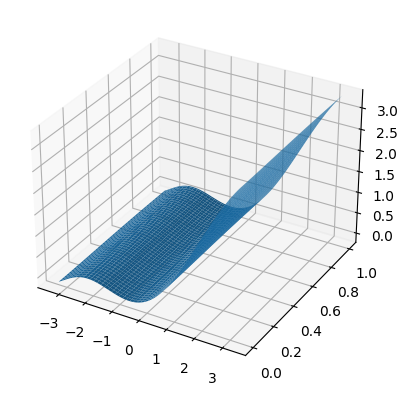


Train Epoch: 40 	Loss: 0.0798910186	Equation Loss: 0.0146096218 	 BC Loss 0.065281
Right_boundary loss 0.0370546915	Left_boundary loss 0.0178635474	Up_boundary loss 0.0103631616


Train Epoch: 40 	Loss: 0.0695775971	Equation Loss: 0.0139220012 	 BC Loss 0.055656
Right_boundary loss 0.0330692828	Left_boundary loss 0.0117794881	Up_boundary loss 0.0108068297


Train Epoch: 40 	Loss: 0.0782540292	Equation Loss: 0.0246875770 	 BC Loss 0.053566
Right_boundary loss 0.0295120496	Left_boundary loss 0.0079398733	Up_boundary loss 0.0161145311


Train Epoch: 40 	Loss: 0.0592127070	Equation Loss: 0.0189059917 	 BC Loss 0.040307
Right_boundary loss 0.0262943693	Left_boundary loss 0.0001828921	Up_boundary loss 0.0138294585

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 40, 	 Actual solution loss: 0.0343903773



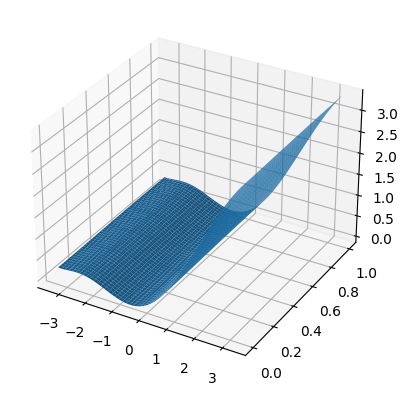


Train Epoch: 41 	Loss: 0.1649657190	Equation Loss: 0.0302319266 	 BC Loss 0.134734
Right_boundary loss 0.0237430278	Left_boundary loss 0.0828767717	Up_boundary loss 0.0281139966


Train Epoch: 41 	Loss: 0.0561628640	Equation Loss: 0.0169459563 	 BC Loss 0.039217
Right_boundary loss 0.0213576704	Left_boundary loss 0.0056439657	Up_boundary loss 0.0122152697


Train Epoch: 41 	Loss: 0.0557137653	Equation Loss: 0.0113556674 	 BC Loss 0.044358
Right_boundary loss 0.0191580243	Left_boundary loss 0.0082874540	Up_boundary loss 0.0169126205


Train Epoch: 41 	Loss: 0.0448115766	Equation Loss: 0.0128688011 	 BC Loss 0.031943
Right_boundary loss 0.0171879083	Left_boundary loss 0.0007828531	Up_boundary loss 0.0139720142

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 41, 	 Actual solution loss: 0.0218915828



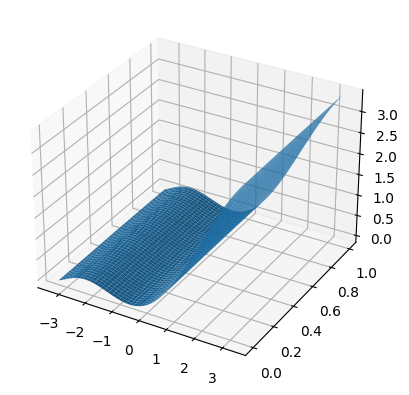


Train Epoch: 42 	Loss: 0.0441721566	Equation Loss: 0.0123778274 	 BC Loss 0.031794
Right_boundary loss 0.0156671368	Left_boundary loss 0.0020254385	Up_boundary loss 0.0141017530


Train Epoch: 42 	Loss: 0.0527252667	Equation Loss: 0.0136777340 	 BC Loss 0.039048
Right_boundary loss 0.0140900342	Left_boundary loss 0.0069863661	Up_boundary loss 0.0179711338


Train Epoch: 42 	Loss: 0.0512279347	Equation Loss: 0.0161427148 	 BC Loss 0.035085
Right_boundary loss 0.0127043994	Left_boundary loss 0.0048796749	Up_boundary loss 0.0175011456


Train Epoch: 42 	Loss: 0.0384670347	Equation Loss: 0.0112553351 	 BC Loss 0.027212
Right_boundary loss 0.0115042068	Left_boundary loss 0.0010473032	Up_boundary loss 0.0146601889

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 42, 	 Actual solution loss: 0.0315978748



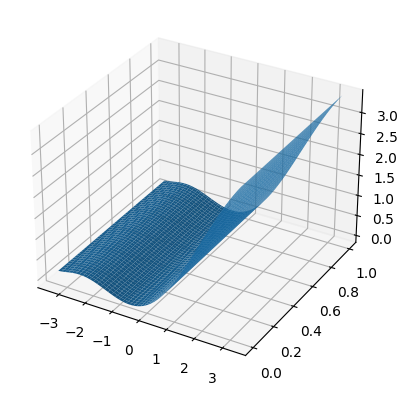


Train Epoch: 43 	Loss: 0.0898547024	Equation Loss: 0.0214150883 	 BC Loss 0.068440
Right_boundary loss 0.0105242124	Left_boundary loss 0.0344966277	Up_boundary loss 0.0234187748


Train Epoch: 43 	Loss: 0.0403171107	Equation Loss: 0.0108297355 	 BC Loss 0.029487
Right_boundary loss 0.0096638044	Left_boundary loss 0.0051384950	Up_boundary loss 0.0146850776


Train Epoch: 43 	Loss: 0.0410125479	Equation Loss: 0.0125411823 	 BC Loss 0.028471
Right_boundary loss 0.0089370087	Left_boundary loss 0.0019472438	Up_boundary loss 0.0175871123


Train Epoch: 43 	Loss: 0.0336294249	Equation Loss: 0.0077078729 	 BC Loss 0.025922
Right_boundary loss 0.0082195690	Left_boundary loss 0.0008221098	Up_boundary loss 0.0168798752

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 43, 	 Actual solution loss: 0.0236264377



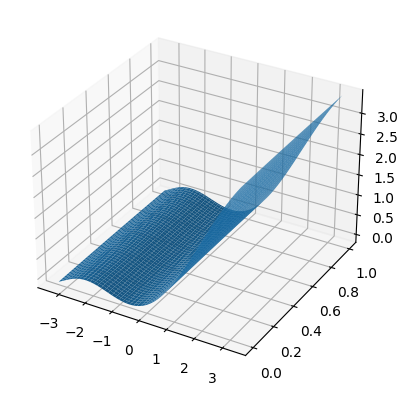


Train Epoch: 44 	Loss: 0.0433599465	Equation Loss: 0.0111063048 	 BC Loss 0.032254
Right_boundary loss 0.0076096808	Left_boundary loss 0.0103555070	Up_boundary loss 0.0142884525


Train Epoch: 44 	Loss: 0.0623869225	Equation Loss: 0.0122734765 	 BC Loss 0.050113
Right_boundary loss 0.0070075537	Left_boundary loss 0.0208754167	Up_boundary loss 0.0222304780


Train Epoch: 44 	Loss: 0.0579405911	Equation Loss: 0.0113443146 	 BC Loss 0.046596
Right_boundary loss 0.0064218133	Left_boundary loss 0.0189779885	Up_boundary loss 0.0211964753


Train Epoch: 44 	Loss: 0.0797007382	Equation Loss: 0.0131952381 	 BC Loss 0.066505
Right_boundary loss 0.0059981644	Left_boundary loss 0.0361944102	Up_boundary loss 0.0243129227

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 44, 	 Actual solution loss: 0.0246025561



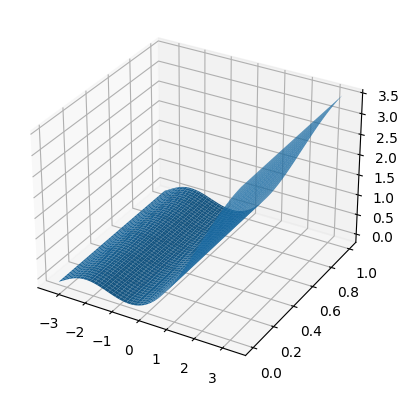


Train Epoch: 45 	Loss: 0.0493602715	Equation Loss: 0.0148282172 	 BC Loss 0.034532
Right_boundary loss 0.0056585129	Left_boundary loss 0.0139239002	Up_boundary loss 0.0149496403


Train Epoch: 45 	Loss: 0.0332732201	Equation Loss: 0.0095300684 	 BC Loss 0.023743
Right_boundary loss 0.0053213243	Left_boundary loss 0.0005241613	Up_boundary loss 0.0178976655


Train Epoch: 45 	Loss: 0.0346236415	Equation Loss: 0.0105415741 	 BC Loss 0.024082
Right_boundary loss 0.0049731042	Left_boundary loss 0.0033112953	Up_boundary loss 0.0157976691


Train Epoch: 45 	Loss: 0.0384612754	Equation Loss: 0.0137589443 	 BC Loss 0.024702
Right_boundary loss 0.0046574534	Left_boundary loss 0.0043904711	Up_boundary loss 0.0156544056

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 45, 	 Actual solution loss: 0.0249081269



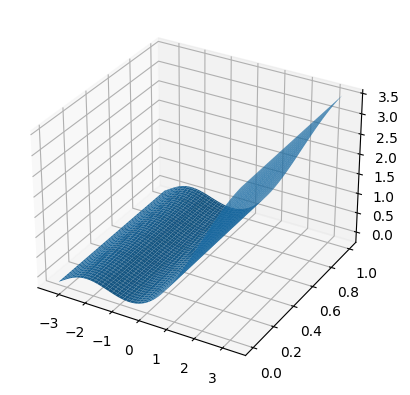


Train Epoch: 46 	Loss: 0.0607636049	Equation Loss: 0.0119539425 	 BC Loss 0.048810
Right_boundary loss 0.0043883710	Left_boundary loss 0.0296807121	Up_boundary loss 0.0147405779


Train Epoch: 46 	Loss: 0.0603271313	Equation Loss: 0.0098275347 	 BC Loss 0.050500
Right_boundary loss 0.0041536149	Left_boundary loss 0.0314539932	Up_boundary loss 0.0148919877


Train Epoch: 46 	Loss: 0.0330061056	Equation Loss: 0.0117507642 	 BC Loss 0.021255
Right_boundary loss 0.0039406680	Left_boundary loss 0.0001840517	Up_boundary loss 0.0171306226


Train Epoch: 46 	Loss: 0.0466552153	Equation Loss: 0.0151178073 	 BC Loss 0.031537
Right_boundary loss 0.0037304952	Left_boundary loss 0.0078476891	Up_boundary loss 0.0199592263

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 46, 	 Actual solution loss: 0.0293058343



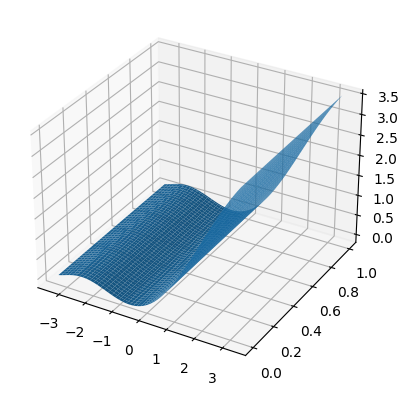


Train Epoch: 47 	Loss: 0.0389766172	Equation Loss: 0.0116397636 	 BC Loss 0.027337
Right_boundary loss 0.0035714568	Left_boundary loss 0.0040606204	Up_boundary loss 0.0197047777


Train Epoch: 47 	Loss: 0.0518597215	Equation Loss: 0.0109295007 	 BC Loss 0.040930
Right_boundary loss 0.0034034539	Left_boundary loss 0.0160647146	Up_boundary loss 0.0214620493


Train Epoch: 47 	Loss: 0.0316878669	Equation Loss: 0.0110792601 	 BC Loss 0.020609
Right_boundary loss 0.0032509533	Left_boundary loss 0.0001719543	Up_boundary loss 0.0171856992


Train Epoch: 47 	Loss: 0.0468070582	Equation Loss: 0.0132915294 	 BC Loss 0.033516
Right_boundary loss 0.0031210717	Left_boundary loss 0.0096218446	Up_boundary loss 0.0207726117

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 47, 	 Actual solution loss: 0.0257403909



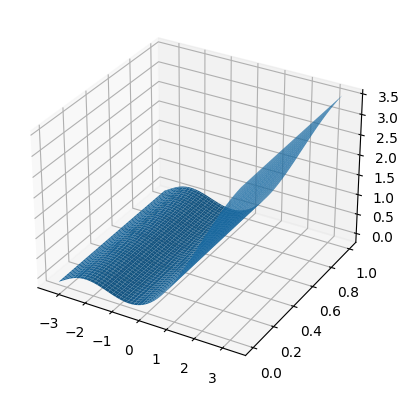


Train Epoch: 48 	Loss: 0.0465446189	Equation Loss: 0.0101058502 	 BC Loss 0.036439
Right_boundary loss 0.0030060797	Left_boundary loss 0.0178700238	Up_boundary loss 0.0155626666


Train Epoch: 48 	Loss: 0.0312200431	Equation Loss: 0.0109850187 	 BC Loss 0.020235
Right_boundary loss 0.0028889114	Left_boundary loss 0.0005120362	Up_boundary loss 0.0168340765


Train Epoch: 48 	Loss: 0.0430367552	Equation Loss: 0.0174897891 	 BC Loss 0.025547
Right_boundary loss 0.0027808612	Left_boundary loss 0.0069472520	Up_boundary loss 0.0158188529


Train Epoch: 48 	Loss: 0.0719536766	Equation Loss: 0.0136527456 	 BC Loss 0.058301
Right_boundary loss 0.0026878500	Left_boundary loss 0.0404363051	Up_boundary loss 0.0151767759

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 48, 	 Actual solution loss: 0.0272082691



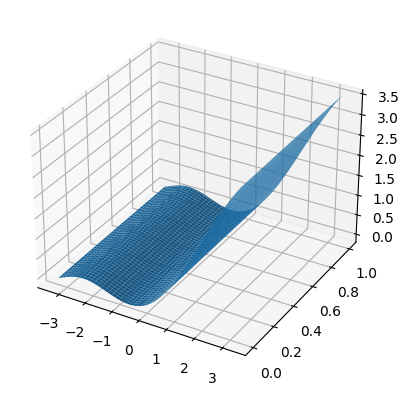


Train Epoch: 49 	Loss: 0.0397984497	Equation Loss: 0.0197145492 	 BC Loss 0.020084
Right_boundary loss 0.0026206162	Left_boundary loss 0.0002530791	Up_boundary loss 0.0172102060


Train Epoch: 49 	Loss: 0.0311623365	Equation Loss: 0.0111455526 	 BC Loss 0.020017
Right_boundary loss 0.0025442382	Left_boundary loss 0.0004224819	Up_boundary loss 0.0170500632


Train Epoch: 49 	Loss: 0.0343924761	Equation Loss: 0.0145484498 	 BC Loss 0.019844
Right_boundary loss 0.0024637992	Left_boundary loss 0.0001436604	Up_boundary loss 0.0172365680


Train Epoch: 49 	Loss: 0.0824322701	Equation Loss: 0.0183447152 	 BC Loss 0.064088
Right_boundary loss 0.0024087622	Left_boundary loss 0.0369375311	Up_boundary loss 0.0247412641

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 49, 	 Actual solution loss: 0.0299838723



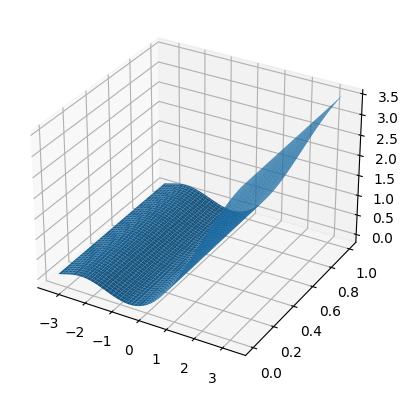


Train Epoch: 50 	Loss: 0.0430364758	Equation Loss: 0.0124716740 	 BC Loss 0.030565
Right_boundary loss 0.0023614985	Left_boundary loss 0.0079107909	Up_boundary loss 0.0202925131


Train Epoch: 50 	Loss: 0.0340633988	Equation Loss: 0.0139400866 	 BC Loss 0.020123
Right_boundary loss 0.0023093752	Left_boundary loss 0.0013434670	Up_boundary loss 0.0164704695


Train Epoch: 50 	Loss: 0.0379271060	Equation Loss: 0.0158522800 	 BC Loss 0.022075
Right_boundary loss 0.0022651104	Left_boundary loss 0.0013623026	Up_boundary loss 0.0184474140


Train Epoch: 50 	Loss: 0.0342968740	Equation Loss: 0.0145266084 	 BC Loss 0.019770
Right_boundary loss 0.0022145505	Left_boundary loss 0.0009796140	Up_boundary loss 0.0165761001

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 50, 	 Actual solution loss: 0.0261474278



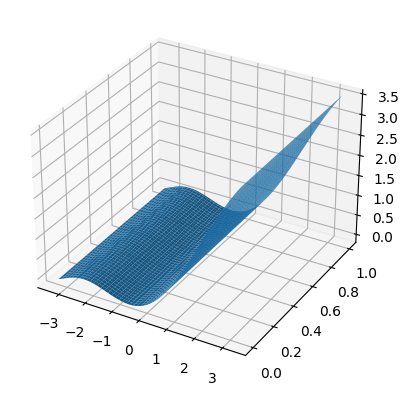


Train Epoch: 51 	Loss: 0.0319832489	Equation Loss: 0.0115121799 	 BC Loss 0.020471
Right_boundary loss 0.0021660069	Left_boundary loss 0.0022629688	Up_boundary loss 0.0160420947


Train Epoch: 51 	Loss: 0.1930227131	Equation Loss: 0.0267200153 	 BC Loss 0.166303
Right_boundary loss 0.0021227917	Left_boundary loss 0.1303109378	Up_boundary loss 0.0338689722


Train Epoch: 51 	Loss: 0.0393393487	Equation Loss: 0.0128604174 	 BC Loss 0.026479
Right_boundary loss 0.0020852576	Left_boundary loss 0.0054601645	Up_boundary loss 0.0189335104


Train Epoch: 51 	Loss: 0.0367568731	Equation Loss: 0.0094174696 	 BC Loss 0.027339
Right_boundary loss 0.0020562566	Left_boundary loss 0.0056380583	Up_boundary loss 0.0196450893

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 51, 	 Actual solution loss: 0.0270149139



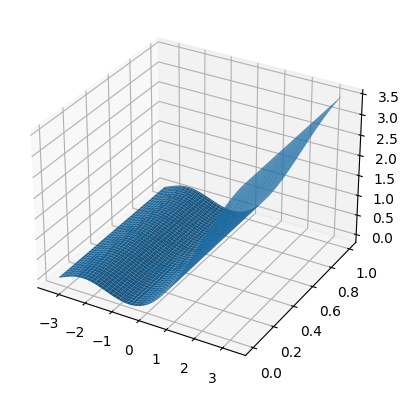


Train Epoch: 52 	Loss: 0.0277752466	Equation Loss: 0.0085343635 	 BC Loss 0.019241
Right_boundary loss 0.0020263093	Left_boundary loss 0.0000905882	Up_boundary loss 0.0171239842


Train Epoch: 52 	Loss: 0.0262280349	Equation Loss: 0.0071264529 	 BC Loss 0.019102
Right_boundary loss 0.0019856049	Left_boundary loss 0.0010467133	Up_boundary loss 0.0160692651


Train Epoch: 52 	Loss: 0.0424950346	Equation Loss: 0.0130645344 	 BC Loss 0.029430
Right_boundary loss 0.0019559963	Left_boundary loss 0.0078980969	Up_boundary loss 0.0195764061


Train Epoch: 52 	Loss: 0.0508228131	Equation Loss: 0.0136219412 	 BC Loss 0.037201
Right_boundary loss 0.0019180528	Left_boundary loss 0.0207415931	Up_boundary loss 0.0145412264

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 52, 	 Actual solution loss: 0.0248702425



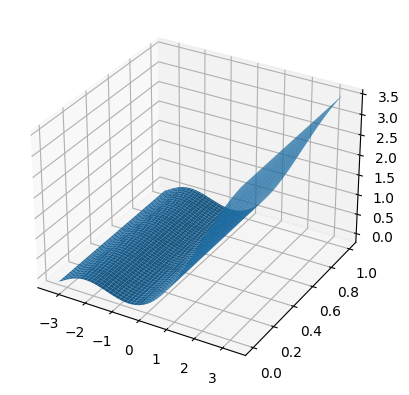


Train Epoch: 53 	Loss: 0.0464026183	Equation Loss: 0.0121147735 	 BC Loss 0.034288
Right_boundary loss 0.0018958156	Left_boundary loss 0.0176710691	Up_boundary loss 0.0147209587


Train Epoch: 53 	Loss: 0.0604628623	Equation Loss: 0.0180871878 	 BC Loss 0.042376
Right_boundary loss 0.0018823170	Left_boundary loss 0.0185969789	Up_boundary loss 0.0218963772


Train Epoch: 53 	Loss: 0.0319629386	Equation Loss: 0.0125592686 	 BC Loss 0.019404
Right_boundary loss 0.0018486403	Left_boundary loss 0.0018471164	Up_boundary loss 0.0157079156


Train Epoch: 53 	Loss: 0.0331011117	Equation Loss: 0.0090039959 	 BC Loss 0.024097
Right_boundary loss 0.0018176129	Left_boundary loss 0.0075242459	Up_boundary loss 0.0147552565

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 53, 	 Actual solution loss: 0.0256012133



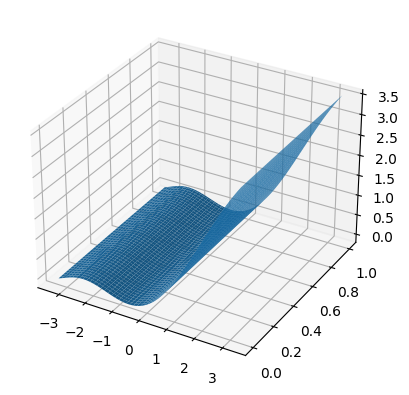


Train Epoch: 54 	Loss: 0.0303443801	Equation Loss: 0.0119737759 	 BC Loss 0.018371
Right_boundary loss 0.0017983189	Left_boundary loss 0.0008798747	Up_boundary loss 0.0156924110


Train Epoch: 54 	Loss: 0.0308840591	Equation Loss: 0.0122080203 	 BC Loss 0.018676
Right_boundary loss 0.0017775840	Left_boundary loss 0.0003809414	Up_boundary loss 0.0165175125


Train Epoch: 54 	Loss: 0.0393651724	Equation Loss: 0.0093474574 	 BC Loss 0.030018
Right_boundary loss 0.0017531511	Left_boundary loss 0.0139924204	Up_boundary loss 0.0142721459


Train Epoch: 54 	Loss: 0.0384597853	Equation Loss: 0.0102875149 	 BC Loss 0.028172
Right_boundary loss 0.0017471100	Left_boundary loss 0.0073723672	Up_boundary loss 0.0190527923

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 54, 	 Actual solution loss: 0.0259576621



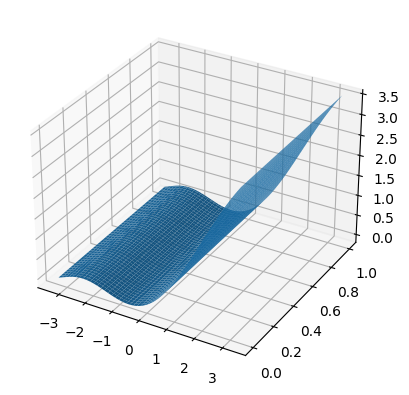


Train Epoch: 55 	Loss: 0.0360578559	Equation Loss: 0.0179498233 	 BC Loss 0.018108
Right_boundary loss 0.0017294451	Left_boundary loss 0.0001132746	Up_boundary loss 0.0162653122


Train Epoch: 55 	Loss: 0.0325047635	Equation Loss: 0.0143707898 	 BC Loss 0.018134
Right_boundary loss 0.0017125809	Left_boundary loss 0.0001921193	Up_boundary loss 0.0162292738


Train Epoch: 55 	Loss: 0.0456777327	Equation Loss: 0.0114090033 	 BC Loss 0.034269
Right_boundary loss 0.0016952206	Left_boundary loss 0.0183199458	Up_boundary loss 0.0142535614


Train Epoch: 55 	Loss: 0.0328755602	Equation Loss: 0.0146796796 	 BC Loss 0.018196
Right_boundary loss 0.0016816083	Left_boundary loss 0.0001525375	Up_boundary loss 0.0163617358

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 55, 	 Actual solution loss: 0.0265220570



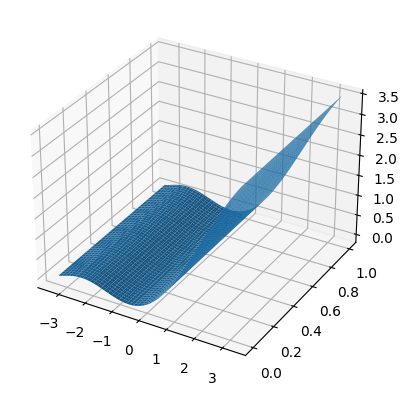


Train Epoch: 56 	Loss: 0.0310810525	Equation Loss: 0.0104741864 	 BC Loss 0.020607
Right_boundary loss 0.0016630783	Left_boundary loss 0.0020344155	Up_boundary loss 0.0169093721


Train Epoch: 56 	Loss: 0.0290908590	Equation Loss: 0.0117351823 	 BC Loss 0.017356
Right_boundary loss 0.0016478455	Left_boundary loss 0.0002615754	Up_boundary loss 0.0154462568


Train Epoch: 56 	Loss: 0.0283313412	Equation Loss: 0.0104831606 	 BC Loss 0.017848
Right_boundary loss 0.0016353854	Left_boundary loss 0.0001725984	Up_boundary loss 0.0160401966


Train Epoch: 56 	Loss: 0.0307715647	Equation Loss: 0.0089363270 	 BC Loss 0.021835
Right_boundary loss 0.0016263422	Left_boundary loss 0.0028543826	Up_boundary loss 0.0173545126

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 56, 	 Actual solution loss: 0.0274341474



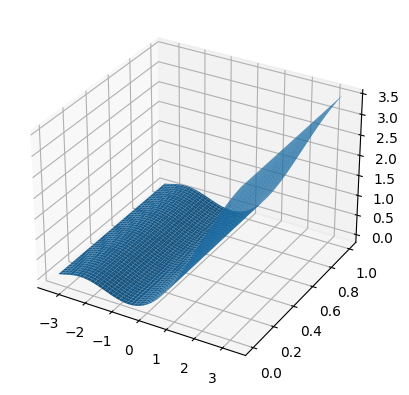


Train Epoch: 57 	Loss: 0.0431676097	Equation Loss: 0.0163036026 	 BC Loss 0.026864
Right_boundary loss 0.0016120544	Left_boundary loss 0.0072021233	Up_boundary loss 0.0180498287


Train Epoch: 57 	Loss: 0.0291694198	Equation Loss: 0.0115330201 	 BC Loss 0.017636
Right_boundary loss 0.0016004229	Left_boundary loss 0.0001679797	Up_boundary loss 0.0158679970


Train Epoch: 57 	Loss: 0.0374752954	Equation Loss: 0.0097832475 	 BC Loss 0.027692
Right_boundary loss 0.0015866031	Left_boundary loss 0.0080702007	Up_boundary loss 0.0180352442


Train Epoch: 57 	Loss: 0.0455407724	Equation Loss: 0.0178858768 	 BC Loss 0.027655
Right_boundary loss 0.0015765175	Left_boundary loss 0.0079100784	Up_boundary loss 0.0181682985

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 57, 	 Actual solution loss: 0.0233883764



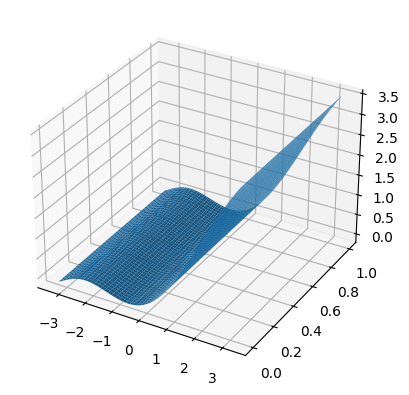


Train Epoch: 58 	Loss: 0.0395359732	Equation Loss: 0.0092955939 	 BC Loss 0.030240
Right_boundary loss 0.0015626628	Left_boundary loss 0.0150501905	Up_boundary loss 0.0136275245


Train Epoch: 58 	Loss: 0.0385740288	Equation Loss: 0.0138748465 	 BC Loss 0.024699
Right_boundary loss 0.0015536509	Left_boundary loss 0.0093098627	Up_boundary loss 0.0138356686


Train Epoch: 58 	Loss: 0.0568977334	Equation Loss: 0.0093504163 	 BC Loss 0.047547
Right_boundary loss 0.0015464689	Left_boundary loss 0.0252928380	Up_boundary loss 0.0207080096


Train Epoch: 58 	Loss: 0.0323253721	Equation Loss: 0.0081495177 	 BC Loss 0.024176
Right_boundary loss 0.0015272546	Left_boundary loss 0.0092361681	Up_boundary loss 0.0134124346

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 58, 	 Actual solution loss: 0.0282479929



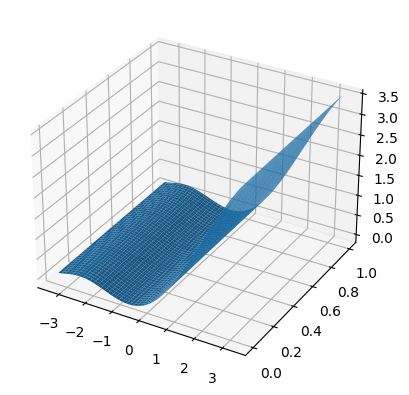


Train Epoch: 59 	Loss: 0.0489011407	Equation Loss: 0.0136093395 	 BC Loss 0.035292
Right_boundary loss 0.0015267383	Left_boundary loss 0.0145826805	Up_boundary loss 0.0191823840


Train Epoch: 59 	Loss: 0.0321290381	Equation Loss: 0.0118857464 	 BC Loss 0.020243
Right_boundary loss 0.0015182658	Left_boundary loss 0.0020340385	Up_boundary loss 0.0166909881


Train Epoch: 59 	Loss: 0.0428640693	Equation Loss: 0.0130427694 	 BC Loss 0.029821
Right_boundary loss 0.0015046827	Left_boundary loss 0.0103060044	Up_boundary loss 0.0180106107


Train Epoch: 59 	Loss: 0.0531819053	Equation Loss: 0.0121463528 	 BC Loss 0.041036
Right_boundary loss 0.0015022232	Left_boundary loss 0.0195400044	Up_boundary loss 0.0199933238

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 59, 	 Actual solution loss: 0.0232453044



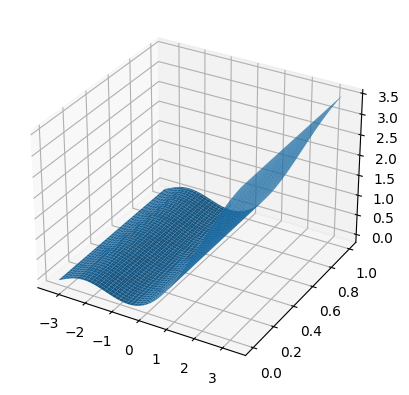


Train Epoch: 60 	Loss: 0.0303769484	Equation Loss: 0.0109133171 	 BC Loss 0.019464
Right_boundary loss 0.0014875393	Left_boundary loss 0.0042344369	Up_boundary loss 0.0137416553


Train Epoch: 60 	Loss: 0.0287060700	Equation Loss: 0.0109616034 	 BC Loss 0.017744
Right_boundary loss 0.0014813411	Left_boundary loss 0.0008253391	Up_boundary loss 0.0154377865


Train Epoch: 60 	Loss: 0.0271852221	Equation Loss: 0.0111191422 	 BC Loss 0.016066
Right_boundary loss 0.0014709254	Left_boundary loss 0.0003746874	Up_boundary loss 0.0142204678


Train Epoch: 60 	Loss: 0.0347644687	Equation Loss: 0.0098968018 	 BC Loss 0.024868
Right_boundary loss 0.0014615038	Left_boundary loss 0.0103761293	Up_boundary loss 0.0130300354

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 60, 	 Actual solution loss: 0.0245789788



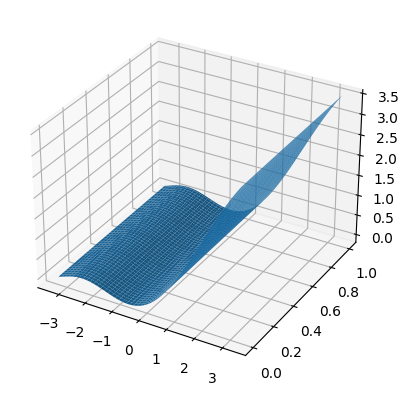


Train Epoch: 61 	Loss: 0.0271808095	Equation Loss: 0.0097157424 	 BC Loss 0.017465
Right_boundary loss 0.0014600997	Left_boundary loss 0.0006274442	Up_boundary loss 0.0153775243


Train Epoch: 61 	Loss: 0.1929818988	Equation Loss: 0.0112352632 	 BC Loss 0.181747
Right_boundary loss 0.0014317770	Left_boundary loss 0.1639996767	Up_boundary loss 0.0163151789


Train Epoch: 61 	Loss: 0.0672726184	Equation Loss: 0.0189759620 	 BC Loss 0.048297
Right_boundary loss 0.0014464468	Left_boundary loss 0.0265947729	Up_boundary loss 0.0202554390


Train Epoch: 61 	Loss: 0.0283348858	Equation Loss: 0.0070937341 	 BC Loss 0.021241
Right_boundary loss 0.0014307197	Left_boundary loss 0.0068164761	Up_boundary loss 0.0129939541

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 61, 	 Actual solution loss: 0.0227908704



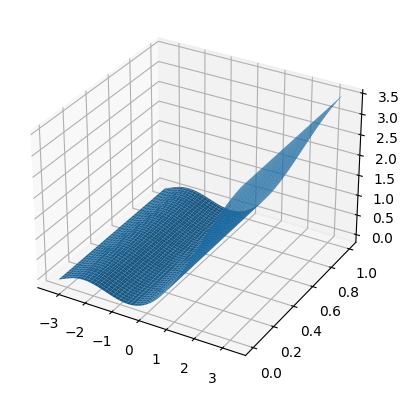


Train Epoch: 62 	Loss: 0.0274597518	Equation Loss: 0.0100524938 	 BC Loss 0.017407
Right_boundary loss 0.0014262364	Left_boundary loss 0.0024901840	Up_boundary loss 0.0134908380


Train Epoch: 62 	Loss: 0.0297768116	Equation Loss: 0.0128947748 	 BC Loss 0.016882
Right_boundary loss 0.0014230396	Left_boundary loss 0.0003913993	Up_boundary loss 0.0150675988


Train Epoch: 62 	Loss: 0.0526841767	Equation Loss: 0.0095023774 	 BC Loss 0.043182
Right_boundary loss 0.0014179799	Left_boundary loss 0.0223775227	Up_boundary loss 0.0193862971


Train Epoch: 62 	Loss: 0.0538126379	Equation Loss: 0.0087550534 	 BC Loss 0.045058
Right_boundary loss 0.0014015675	Left_boundary loss 0.0313472040	Up_boundary loss 0.0123088146

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 62, 	 Actual solution loss: 0.0223676938



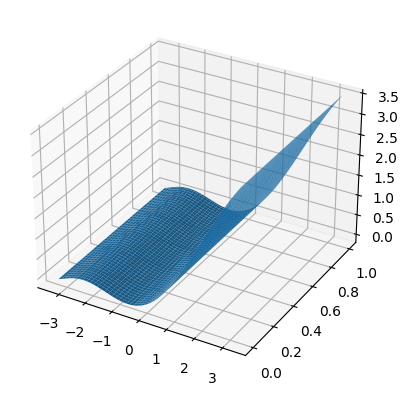


Train Epoch: 63 	Loss: 0.0252370816	Equation Loss: 0.0089262705 	 BC Loss 0.016311
Right_boundary loss 0.0013921483	Left_boundary loss 0.0018800655	Up_boundary loss 0.0130385961


Train Epoch: 63 	Loss: 0.0529620238	Equation Loss: 0.0114937620 	 BC Loss 0.041468
Right_boundary loss 0.0013902534	Left_boundary loss 0.0214603376	Up_boundary loss 0.0186176710


Train Epoch: 63 	Loss: 0.0325235352	Equation Loss: 0.0117358407 	 BC Loss 0.020788
Right_boundary loss 0.0013875101	Left_boundary loss 0.0033003085	Up_boundary loss 0.0160998758


Train Epoch: 63 	Loss: 0.0436410010	Equation Loss: 0.0101415720 	 BC Loss 0.033499
Right_boundary loss 0.0013698180	Left_boundary loss 0.0200539883	Up_boundary loss 0.0120756207

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 63, 	 Actual solution loss: 0.0223796817



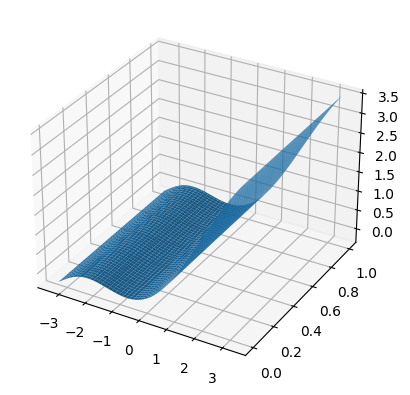


Train Epoch: 64 	Loss: 0.0940936729	Equation Loss: 0.0106940614 	 BC Loss 0.083400
Right_boundary loss 0.0013564307	Left_boundary loss 0.0695568994	Up_boundary loss 0.0124862781


Train Epoch: 64 	Loss: 0.0275176577	Equation Loss: 0.0108515983 	 BC Loss 0.016666
Right_boundary loss 0.0013597176	Left_boundary loss 0.0008803000	Up_boundary loss 0.0144260433


Train Epoch: 64 	Loss: 0.0303948298	Equation Loss: 0.0149995731 	 BC Loss 0.015395
Right_boundary loss 0.0013516325	Left_boundary loss 0.0001699397	Up_boundary loss 0.0138736833


Train Epoch: 64 	Loss: 0.0434831604	Equation Loss: 0.0113987196 	 BC Loss 0.032084
Right_boundary loss 0.0013386433	Left_boundary loss 0.0189998373	Up_boundary loss 0.0117459595

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 64, 	 Actual solution loss: 0.0257687631



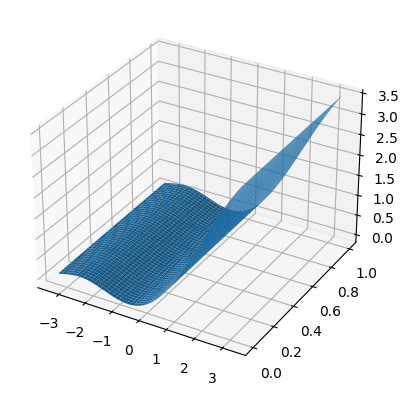


Train Epoch: 65 	Loss: 0.0447361246	Equation Loss: 0.0142023079 	 BC Loss 0.030534
Right_boundary loss 0.0013426857	Left_boundary loss 0.0121335248	Up_boundary loss 0.0170576070


Train Epoch: 65 	Loss: 0.0286509097	Equation Loss: 0.0087191984 	 BC Loss 0.019932
Right_boundary loss 0.0013303198	Left_boundary loss 0.0062967418	Up_boundary loss 0.0123046506


Train Epoch: 65 	Loss: 0.0323036760	Equation Loss: 0.0125728864 	 BC Loss 0.019731
Right_boundary loss 0.0013219393	Left_boundary loss 0.0063070701	Up_boundary loss 0.0121017825


Train Epoch: 65 	Loss: 0.0660817102	Equation Loss: 0.0091494331 	 BC Loss 0.056932
Right_boundary loss 0.0013136972	Left_boundary loss 0.0438968390	Up_boundary loss 0.0117217433

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 65, 	 Actual solution loss: 0.0238334422



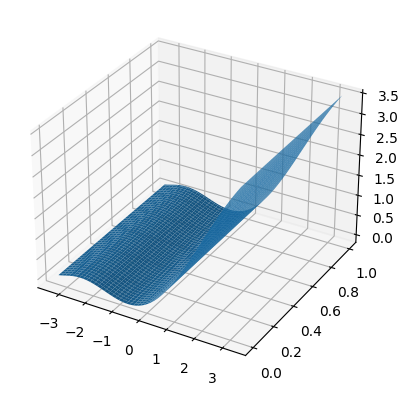


Train Epoch: 66 	Loss: 0.0343304649	Equation Loss: 0.0138352495 	 BC Loss 0.020495
Right_boundary loss 0.0013139199	Left_boundary loss 0.0041122027	Up_boundary loss 0.0150690936


Train Epoch: 66 	Loss: 0.0313843973	Equation Loss: 0.0124532627 	 BC Loss 0.018931
Right_boundary loss 0.0013077002	Left_boundary loss 0.0027912012	Up_boundary loss 0.0148322321


Train Epoch: 66 	Loss: 0.0699282289	Equation Loss: 0.0099576637 	 BC Loss 0.059971
Right_boundary loss 0.0012939617	Left_boundary loss 0.0470477864	Up_boundary loss 0.0116288206


Train Epoch: 66 	Loss: 0.0235321000	Equation Loss: 0.0080684964 	 BC Loss 0.015464
Right_boundary loss 0.0012897906	Left_boundary loss 0.0018782312	Up_boundary loss 0.0122955814

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 66, 	 Actual solution loss: 0.0205487615



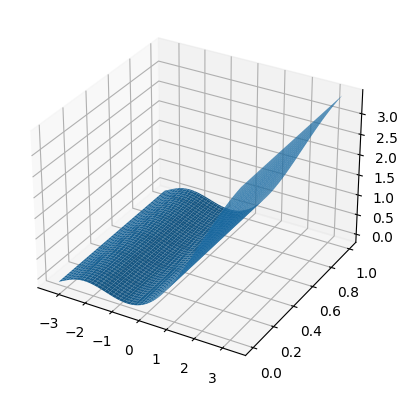


Train Epoch: 67 	Loss: 0.0345131718	Equation Loss: 0.0086677335 	 BC Loss 0.025845
Right_boundary loss 0.0012813311	Left_boundary loss 0.0131561337	Up_boundary loss 0.0114079723


Train Epoch: 67 	Loss: 0.0269000940	Equation Loss: 0.0117356433 	 BC Loss 0.015164
Right_boundary loss 0.0012783101	Left_boundary loss 0.0014766668	Up_boundary loss 0.0124094738


Train Epoch: 67 	Loss: 0.0589234903	Equation Loss: 0.0079256846 	 BC Loss 0.050998
Right_boundary loss 0.0012662875	Left_boundary loss 0.0384833850	Up_boundary loss 0.0112481341


Train Epoch: 67 	Loss: 0.0361914188	Equation Loss: 0.0099272681 	 BC Loss 0.026264
Right_boundary loss 0.0012645811	Left_boundary loss 0.0136421379	Up_boundary loss 0.0113574304

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 67, 	 Actual solution loss: 0.0241392950



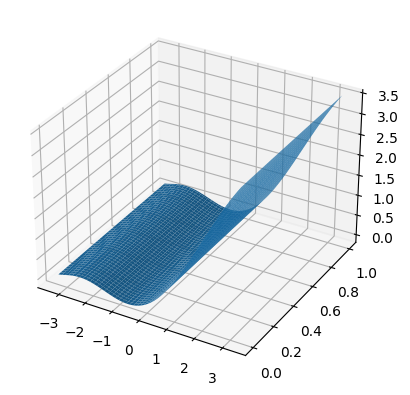


Train Epoch: 68 	Loss: 0.0354878008	Equation Loss: 0.0111312177 	 BC Loss 0.024357
Right_boundary loss 0.0012664938	Left_boundary loss 0.0073449593	Up_boundary loss 0.0157451332


Train Epoch: 68 	Loss: 0.0278841406	Equation Loss: 0.0120882308 	 BC Loss 0.015796
Right_boundary loss 0.0012568090	Left_boundary loss 0.0009226237	Up_boundary loss 0.0136164771


Train Epoch: 68 	Loss: 0.0317620039	Equation Loss: 0.0079809660 	 BC Loss 0.023781
Right_boundary loss 0.0012471838	Left_boundary loss 0.0112753436	Up_boundary loss 0.0112585127


Train Epoch: 68 	Loss: 0.0438143015	Equation Loss: 0.0083735520 	 BC Loss 0.035441
Right_boundary loss 0.0012371386	Left_boundary loss 0.0233157706	Up_boundary loss 0.0108878408

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 68, 	 Actual solution loss: 0.0270977756



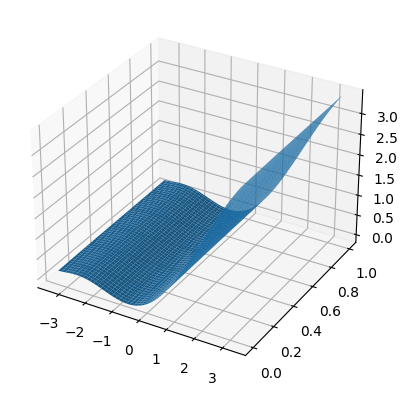


Train Epoch: 69 	Loss: 0.0612563081	Equation Loss: 0.0083846627 	 BC Loss 0.052872
Right_boundary loss 0.0012410540	Left_boundary loss 0.0329023935	Up_boundary loss 0.0187281985


Train Epoch: 69 	Loss: 0.0597376302	Equation Loss: 0.0148412669 	 BC Loss 0.044896
Right_boundary loss 0.0012389227	Left_boundary loss 0.0253221132	Up_boundary loss 0.0183353275


Train Epoch: 69 	Loss: 0.0294071063	Equation Loss: 0.0092561785 	 BC Loss 0.020151
Right_boundary loss 0.0012230283	Left_boundary loss 0.0077365790	Up_boundary loss 0.0111913206


Train Epoch: 69 	Loss: 0.0273298789	Equation Loss: 0.0087803714 	 BC Loss 0.018550
Right_boundary loss 0.0012174522	Left_boundary loss 0.0061362125	Up_boundary loss 0.0111958431

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 69, 	 Actual solution loss: 0.0198537102



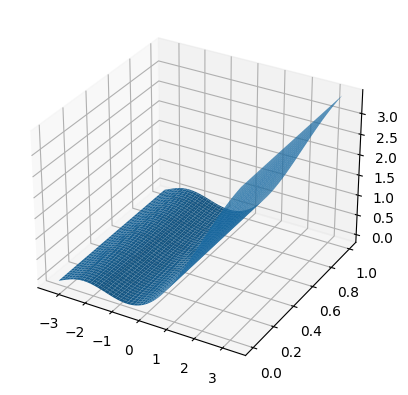


Train Epoch: 70 	Loss: 0.0252554417	Equation Loss: 0.0067661982 	 BC Loss 0.018489
Right_boundary loss 0.0012097448	Left_boundary loss 0.0062586730	Up_boundary loss 0.0110208252


Train Epoch: 70 	Loss: 0.0504639223	Equation Loss: 0.0101080853 	 BC Loss 0.040356
Right_boundary loss 0.0012057869	Left_boundary loss 0.0283931382	Up_boundary loss 0.0107569126


Train Epoch: 70 	Loss: 0.0290621724	Equation Loss: 0.0129415821 	 BC Loss 0.016121
Right_boundary loss 0.0012038695	Left_boundary loss 0.0015142774	Up_boundary loss 0.0134024434


Train Epoch: 70 	Loss: 0.0451659411	Equation Loss: 0.0141618736 	 BC Loss 0.031004
Right_boundary loss 0.0012011625	Left_boundary loss 0.0138517581	Up_boundary loss 0.0159511473

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 70, 	 Actual solution loss: 0.0210971898



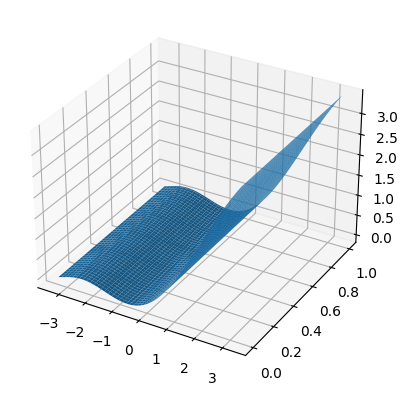


Train Epoch: 71 	Loss: 0.0237884317	Equation Loss: 0.0096189072 	 BC Loss 0.014170
Right_boundary loss 0.0011916003	Left_boundary loss 0.0003521758	Up_boundary loss 0.0126257483


Train Epoch: 71 	Loss: 0.0226527676	Equation Loss: 0.0093094632 	 BC Loss 0.013343
Right_boundary loss 0.0011820915	Left_boundary loss 0.0006001187	Up_boundary loss 0.0115610948


Train Epoch: 71 	Loss: 0.0693216696	Equation Loss: 0.0080935070 	 BC Loss 0.061228
Right_boundary loss 0.0011734384	Left_boundary loss 0.0493345149	Up_boundary loss 0.0107202092


Train Epoch: 71 	Loss: 0.0287741441	Equation Loss: 0.0102022290 	 BC Loss 0.018572
Right_boundary loss 0.0011773729	Left_boundary loss 0.0036279121	Up_boundary loss 0.0137666306

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 71, 	 Actual solution loss: 0.0222340435



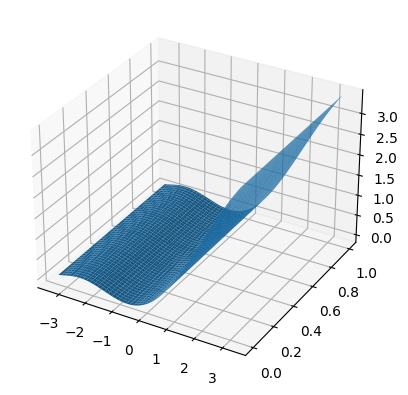


Train Epoch: 72 	Loss: 0.0365145653	Equation Loss: 0.0159070678 	 BC Loss 0.020607
Right_boundary loss 0.0011706467	Left_boundary loss 0.0054402649	Up_boundary loss 0.0139965834


Train Epoch: 72 	Loss: 0.0334826633	Equation Loss: 0.0089388434 	 BC Loss 0.024544
Right_boundary loss 0.0011629753	Left_boundary loss 0.0128642078	Up_boundary loss 0.0105166379


Train Epoch: 72 	Loss: 0.0371799357	Equation Loss: 0.0100271869 	 BC Loss 0.027153
Right_boundary loss 0.0011554669	Left_boundary loss 0.0156550817	Up_boundary loss 0.0103421994


Train Epoch: 72 	Loss: 0.0270669367	Equation Loss: 0.0121596400 	 BC Loss 0.014907
Right_boundary loss 0.0011514080	Left_boundary loss 0.0011888787	Up_boundary loss 0.0125670098

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 72, 	 Actual solution loss: 0.0188841418



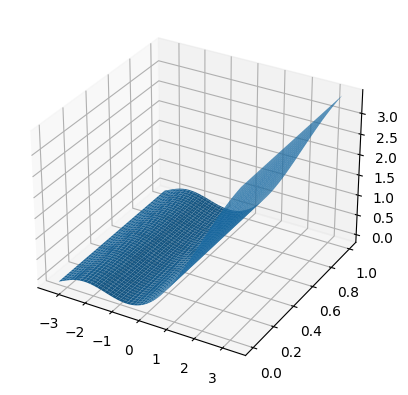


Train Epoch: 73 	Loss: 0.0311915614	Equation Loss: 0.0096724629 	 BC Loss 0.021519
Right_boundary loss 0.0011404180	Left_boundary loss 0.0101716397	Up_boundary loss 0.0102070412


Train Epoch: 73 	Loss: 0.0622769967	Equation Loss: 0.0116312075 	 BC Loss 0.050646
Right_boundary loss 0.0011381847	Left_boundary loss 0.0391638428	Up_boundary loss 0.0103437593


Train Epoch: 73 	Loss: 0.0704282448	Equation Loss: 0.0184712186 	 BC Loss 0.051957
Right_boundary loss 0.0011387831	Left_boundary loss 0.0327674448	Up_boundary loss 0.0180507973


Train Epoch: 73 	Loss: 0.0484182015	Equation Loss: 0.0125553310 	 BC Loss 0.035863
Right_boundary loss 0.0011339735	Left_boundary loss 0.0188480839	Up_boundary loss 0.0158808157

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 73, 	 Actual solution loss: 0.0187064346



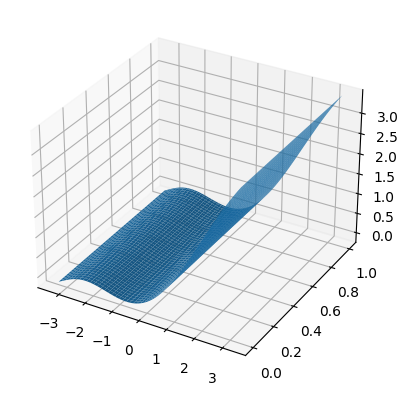


Train Epoch: 74 	Loss: 0.0426923297	Equation Loss: 0.0084104771 	 BC Loss 0.034282
Right_boundary loss 0.0011203019	Left_boundary loss 0.0232518055	Up_boundary loss 0.0099097462


Train Epoch: 74 	Loss: 0.0581724197	Equation Loss: 0.0090880562 	 BC Loss 0.049084
Right_boundary loss 0.0011245402	Left_boundary loss 0.0307334159	Up_boundary loss 0.0172264110


Train Epoch: 74 	Loss: 0.0278655887	Equation Loss: 0.0090388060 	 BC Loss 0.018827
Right_boundary loss 0.0011121822	Left_boundary loss 0.0074893297	Up_boundary loss 0.0102252718


Train Epoch: 74 	Loss: 0.0243878476	Equation Loss: 0.0081415316 	 BC Loss 0.016246
Right_boundary loss 0.0011087583	Left_boundary loss 0.0046796720	Up_boundary loss 0.0104578855

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 74, 	 Actual solution loss: 0.0184368797



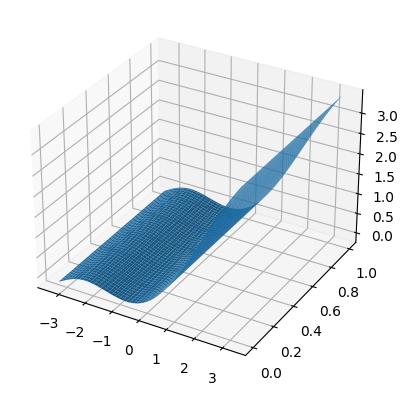


Train Epoch: 75 	Loss: 0.0422524214	Equation Loss: 0.0077719614 	 BC Loss 0.034480
Right_boundary loss 0.0011008290	Left_boundary loss 0.0235681273	Up_boundary loss 0.0098115029


Train Epoch: 75 	Loss: 0.0313983262	Equation Loss: 0.0101796119 	 BC Loss 0.021219
Right_boundary loss 0.0011038906	Left_boundary loss 0.0064163627	Up_boundary loss 0.0136984615


Train Epoch: 75 	Loss: 0.0213230606	Equation Loss: 0.0087229107 	 BC Loss 0.012600
Right_boundary loss 0.0010968633	Left_boundary loss 0.0001013312	Up_boundary loss 0.0114019550


Train Epoch: 75 	Loss: 0.1184654534	Equation Loss: 0.0171337109 	 BC Loss 0.101332
Right_boundary loss 0.0010975515	Left_boundary loss 0.0776805282	Up_boundary loss 0.0225536637

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 75, 	 Actual solution loss: 0.0183223098



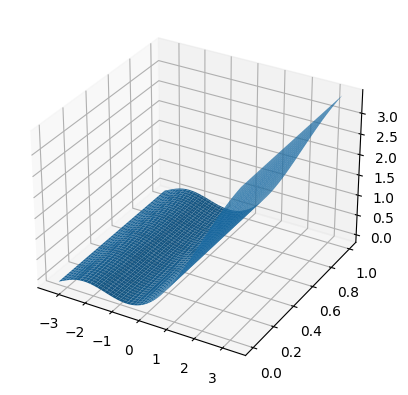


Train Epoch: 76 	Loss: 0.0311695952	Equation Loss: 0.0108322967 	 BC Loss 0.020337
Right_boundary loss 0.0010844800	Left_boundary loss 0.0092916386	Up_boundary loss 0.0099611804


Train Epoch: 76 	Loss: 0.0236990638	Equation Loss: 0.0109310690 	 BC Loss 0.012768
Right_boundary loss 0.0010789792	Left_boundary loss 0.0002902623	Up_boundary loss 0.0113987532


Train Epoch: 76 	Loss: 0.0456326790	Equation Loss: 0.0085064834 	 BC Loss 0.037126
Right_boundary loss 0.0010696746	Left_boundary loss 0.0265487544	Up_boundary loss 0.0095077660


Train Epoch: 76 	Loss: 0.0446406752	Equation Loss: 0.0107131386 	 BC Loss 0.033928
Right_boundary loss 0.0010665071	Left_boundary loss 0.0233147256	Up_boundary loss 0.0095463060

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 76, 	 Actual solution loss: 0.0215970377



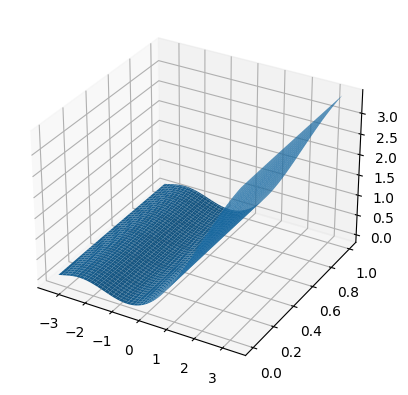


Train Epoch: 77 	Loss: 0.0328967571	Equation Loss: 0.0112443995 	 BC Loss 0.021652
Right_boundary loss 0.0010719618	Left_boundary loss 0.0067738905	Up_boundary loss 0.0138065033


Train Epoch: 77 	Loss: 0.0780294165	Equation Loss: 0.0147563638 	 BC Loss 0.063273
Right_boundary loss 0.0010646926	Left_boundary loss 0.0438700765	Up_boundary loss 0.0183382798


Train Epoch: 77 	Loss: 0.0292983390	Equation Loss: 0.0099797621 	 BC Loss 0.019319
Right_boundary loss 0.0010535503	Left_boundary loss 0.0086112311	Up_boundary loss 0.0096537955


Train Epoch: 77 	Loss: 0.0371402577	Equation Loss: 0.0108760651 	 BC Loss 0.026264
Right_boundary loss 0.0010571576	Left_boundary loss 0.0109277321	Up_boundary loss 0.0142793059

[[1.35949282e-06]
 [1.74462451e-06]
 [2.24164250e-06]
 ...
 [2.38947809e+00]
 [2.43978289e+00]
 [2.49008769e+00]]

After Epoch 77, 	 Actual solution loss: 0.0228788179



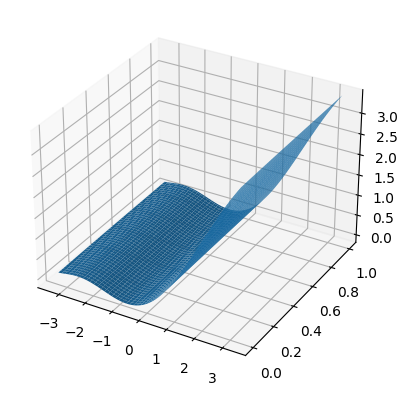


Train Epoch: 78 	Loss: 0.0438707583	Equation Loss: 0.0090580517 	 BC Loss 0.034813
Right_boundary loss 0.0010513987	Left_boundary loss 0.0185590666	Up_boundary loss 0.0152022429


Train Epoch: 78 	Loss: 0.0447814241	Equation Loss: 0.0085579213 	 BC Loss 0.036224
Right_boundary loss 0.0010350950	Left_boundary loss 0.0259418562	Up_boundary loss 0.0092465505



KeyboardInterrupt: 

In [52]:
basis_num = 10
epochs = 250
learning_rate = 1e-3  

batchsize = 128 
batch_flag = True
output = train(device,x,t,x_bound,t_bound,v_bound,learning_rate,basis_num,epochs,batch_flag,batchsize)


In [9]:
arr = output[1].detach().numpy()
plt.plot(arr)
plt.plot(v_up)

NameError: name 'output' is not defined

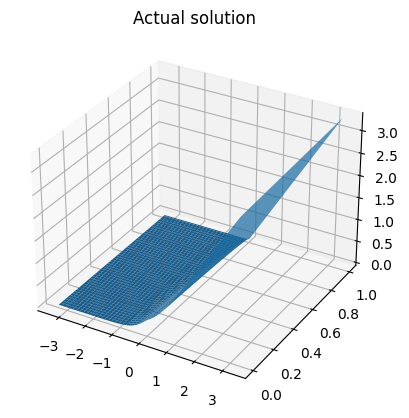

In [75]:
x = np.linspace(x_start,x_end,100);y = np.linspace(t_start,t_end,100)
x,y = np.meshgrid(x,y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x,y,actual_soln.reshape(100,100))
plt.title('Actual solution')
plt.show()